What I learned:

14/11/2024:

**Task:** get the crossroads with the most accidents<br>
**Challenge:** ta_crossroads is using multi string for it's crosswalk, crosswalk can be used as a crossroad.<br>
Some crosswalk can be combined to represent a crossroad.

In order to get accidents in a crossroad, we need to turn the crosswalk to a polygon and merge any relating polygon crosswalks together.

**Solution:**
```
# Convex_hull turns any related group of points to a polygon.
ta_crossroads_['geometry'] = ta_crossroads_.geometry.convex_hull.buffer(10)  # Adjust buffer size

# Combine all geometries into a single multipolygon with merged overlaps
# This step will merge any overlapping polygons into a single geometry
merged_geometry = unary_union(ta_crossroads_.geometry)

# If you want each connected component as a separate polygon, convert the multipolygon back to individual polygons
crossroads_poly = gpd.GeoDataFrame(geometry=[merged_geometry], crs=ta_crossroads_.crs)

# Explode into individual polygons if merged into a MultiPolygon
crossroads_poly = crossroads_poly.explode(index_parts=True).reset_index(drop=True)
```

**Next problem:**<br>
We don't know what the created polygons relate to street wise.<br>
**Idea for a Solution:** use ta_street and ta_crossroads, *sjoin* them and get the names from the merged result 

---- 

16/11/2024

### Problem: Visualizing polygons and count next to them
When visualizing polygons and their related data on a map, it's often necessary to annotate each polygon with additional information. In this case, we want to display the counts of `index_right` (obtained from `i_m_h_ta_mm_crossroads_gdf_.value_counts(subset='index_right')`) above the corresponding polygons. The challenge is to position these annotations clearly without overlapping the polygons.

### Solution
To solve this:
1. Calculated the counts of `index_right` using `value_counts`.
2. Filtered the polygons from `crossroads_poly` to include only those matching the relevant indices.
3. Used the centroid of each polygon to determine the annotation position, applying a vertical offset to ensure the text is displayed above the polygon.

Here’s the implementation:

```python
# Step 1: Get the count of `index_right`
counts = i_m_h_ta_mm_crossroads_gdf_.value_counts(subset='index_right')

# Step 2: Prepare the figure and axes
fig, ax = plt.subplots(figsize=(15, 15))

# Plot the points and polygons
i_m_h_ta_mm_crossroads_gdf_t10.plot(ax=ax, color='red', marker='o', markersize=1, alpha=0.5, label="Crossroads")
filtered_crossroads = crossroads_poly[crossroads_poly.index.isin(i_m_h_ta_mm_crossroads_gdf_t10.index_right)]
filtered_crossroads.plot(ax=ax, color='black', alpha=0.5, label="Polygons")

# Step 3: Annotate polygons with counts
for idx, row in filtered_crossroads.iterrows():
    count = counts.get(idx, 0)
    centroid = row.geometry.centroid
    ax.text(
        centroid.x, centroid.y + 0.01,  # Offset to place text above
        str(count), fontsize=10, color="blue", ha='center', va='bottom',
        bbox=dict(facecolor='white', alpha=0.5)
    )

# Display the plot
plt.legend()
plt.show()
```

----

### Problem: Filling Missing Grouped Values in a DataFrame While Preserving Structure

You have a pandas DataFrame containing information about crossroads, including the names of two intersecting streets (`street1_hebrew` and `street2_hebrew`) and a combined `crossroad_name`. In some cases:

1. The `crossroad_name` column contains NaN values.
2. The same crossroad can appear multiple times with the same `index_right` value.
3. The `crossroad_name` values for the same `index_right` may differ or have NaN values.

The goal is to:
- Replace all NaN values in the `crossroad_name` column for a specific `index_right` group with the first non-NaN value from that group.
- Ensure that the DataFrame structure, including `index_right`, remains unchanged.

### Additional Problem

While attempting to solve the problem using `groupby` with the `.apply()` method, the structure of the `index_right` column was altered, leading to issues with the integrity of the DataFrame. Specifically:
- The `index_right` column was modified or removed.
- The alignment of rows in the output was not consistent with the original DataFrame.

### Solution

To solve the problem while preserving the structure of the DataFrame and the `index_right` column, the following approach was used:

1. Use the `.groupby()` method with the `transform()` function to perform group-wise operations while maintaining the original DataFrame's structure.
2. Within each group, use a lambda function to find the first non-NaN value in the `crossroad_name` column.
3. Assign this value to all rows within the same `index_right` group.
4. Ensure that groups with all NaN values in the `crossroad_name` column remain NaN.

Here’s the implementation:

```
# Use transform to preserve the structure and avoid changing the index
# Fill each group's NaN values in `crossroad_name` with the first non-NaN value
i_m_h_ta_mm_crossroads_gdf['crossroad_name'] = (
    i_m_h_ta_mm_crossroads_gdf
    .groupby('index_right')['crossroad_name']
    .transform(lambda x: x.dropna().iloc[0] if not x.dropna().empty else None)
)

# View the updated DataFrame
i_m_h_ta_mm_crossroads_gdf
```

-----

### Problem: Counting the number of unique values for each index_right

This check was needed to see if changing the names of the crossroad_name worked properly
### Solution:
```
unique_counts = (
    i_m_h_ta_mm_crossroads_gdf.groupby('index_right')
    .agg(
        unique_street1_hebrew=('street1_hebrew', lambda x: x.nunique(dropna=True)),
        unique_street2_hebrew=('street2_hebrew', lambda x: x.nunique(dropna=True))
    )
    .reset_index()
)
```
----

### Markdown Cell: Problem Statement
"""
### Problem: Creating Valid Crossroads from Street Intersections

When working with street network data (`ta_streets`), a common challenge is to generate valid crossroads from intersections between street segments. These crossroads are required to have specific characteristics, such as consistent geometry and logical splitting based on defined lengths. Additionally, the resulting crossroads need to be buffered into polygons, and overlapping polygons must be merged appropriately.
"""

# Markdown Cell: Solution Overview
"""
### Solution

To solve this:
1. **Split LineStrings**: The streets are split into smaller LineStrings based on a defined length using the `split_linestrings_by_length` function. This ensures each street part is divided into manageable segments.
2. **Buffer LineStrings**: Each split segment is buffered into a polygon to represent the spatial extent of the crossroads.
3. **Merge Overlapping Polygons**: The buffered polygons are merged by dissolving the GeoDataFrame and exploding the resulting MultiPolygon into individual Polygon components.
4. **Filter by Length**: A filter is applied to remove polygons that result in unusually small or excessively long geometries.
"""

```
# Code Cell: Implementation
# Import necessary libraries
from shapely.geometry import LineString
import geopandas as gpd

def split_linestrings_by_length(gdf, split_length=10):
    """Split each LineString in a GeoDataFrame into two LineStrings:
    one starting from the start point with the specified length
    and one ending at the endpoint with the specified length."""
    new_rows = []
    
    for i, row in gdf.iterrows():
        geometry = row.geometry
        
        # Check if the geometry is a LineString
        if isinstance(geometry, LineString):
            length = geometry.length
            
            # Ensure the split length is valid
            if split_length * 2 >= length:
                continue  # Skip splitting if split length exceeds the total length
            
            # Compute the two split points
            split_point_start = geometry.interpolate(split_length)
            split_point_end = geometry.interpolate(length - split_length)
            
            # Create two new LineStrings
            first_segment = LineString([geometry.coords[0], split_point_start.coords[0]])
            second_segment = LineString([split_point_end.coords[0], geometry.coords[-1]])
            
            # Append new rows with the original attributes and new geometries
            new_rows.append({**row.to_dict(), "geometry": first_segment})
            new_rows.append({**row.to_dict(), "geometry": second_segment})
    
    # Create a new GeoDataFrame with the split LineStrings
    return gpd.GeoDataFrame(new_rows, crs=gdf.crs)

# Example data for demonstration
data = {
    "id": [1, 2],
    "geometry": [
        LineString([(0, 0), (20, 0)]),
        LineString([(0, 0), (0, 30)]),
    ],
}
example_gdf = gpd.GeoDataFrame(data, crs="EPSG:4326")

# Step 1: Split the LineStrings with a length of 10
ta_crossroads_from_streets = split_linestrings_by_length(example_gdf, split_length=10)

# Step 2: Buffer the split LineStrings to create polygons
ta_crossroads_from_streets['geometry'] = ta_crossroads_from_streets.geometry.buffer(5)

# Step 3: Merge overlapping polygons
combined_polygons = ta_crossroads_from_streets.dissolve().explode()

# Step 4: Filter polygons by length
combined_polygons['geo_length'] = combined_polygons.geometry.length
combined_polygons = combined_polygons.reset_index().drop(columns=['level_1', 'level_0'])
```

In [1]:
import matplotlib.pyplot as plt
from shapely.geometry import Point
import geopandas as gpd
import pandas as pd
import numpy as np
from IPython.display import Image, display

In [2]:
ta_q = gpd.read_file("./csv_tables/TA_Quaters_UTM/Quarters.shp")
ta_q.oidrova = pd.to_numeric(ta_q.oidrova, downcast='integer')
ta_q.krova = pd.to_numeric(ta_q.krova, downcast='integer')
display(ta_q.crs)
ta_q

<Projected CRS: EPSG:32636>
Name: WGS 84 / UTM zone 36N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 30°E and 36°E, northern hemisphere between equator and 84°N, onshore and offshore. Belarus. Cyprus. Egypt. Ethiopia. Finland. Israel. Jordan. Kenya. Lebanon. Moldova. Norway. Russian Federation. Saudi Arabia. Sudan. Syria. Türkiye (Turkey). Uganda. Ukraine.
- bounds: (30.0, 0.0, 36.0, 84.0)
Coordinate Operation:
- name: UTM zone 36N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

oidrova  krova           dateimport     ShapeArea  \
0        1      1  01/12/2015 02:28:14  1.301654e+07   
1        2      2  01/12/2015 02:28:14  8.013404e+06   
2        3      3  01/12/2015 02:28:14  3.380430e+06   
3        4      4  01/12/2015 02:28:14  4.510255e+06   
4        5      6  01/12/2015 02:28:14  2.089044e+06   
5        6      9  01/12/2015 02:28:14  7.879856e+06   
6        7      5  01/12/2015 02:28:14  3.024297e+06   
7        8      8  01/12/2015 02:28:14  3.420996e+06   
8        9      7  01/12/2015 02:28:14  6.343551e+06   

                                            geometry  
0  POLYGON ((670795.655 3555762.452, 670797.577 3...  
1  POLYGON ((672021.029 3553364.492, 672014.690 3...  
2  POLYGON ((668311.070 3552547.701, 668311.229 3...  
3  POLYGON ((670771.828 3552544.564, 670771.584 3...  
4  POLYGON ((668160.048 3550196.192, 668162.425 3...  
5  POLYGON ((668811.121 3546980.368, 668808.698 3...  
6  POLYGON ((666698.783 3550619.396, 666701.339 3...  
7  POLYGON ((667954.133 3548820.374, 667956.725 3...  
8  POLYGON ((665854.540 3548193.053, 665868.137 3...

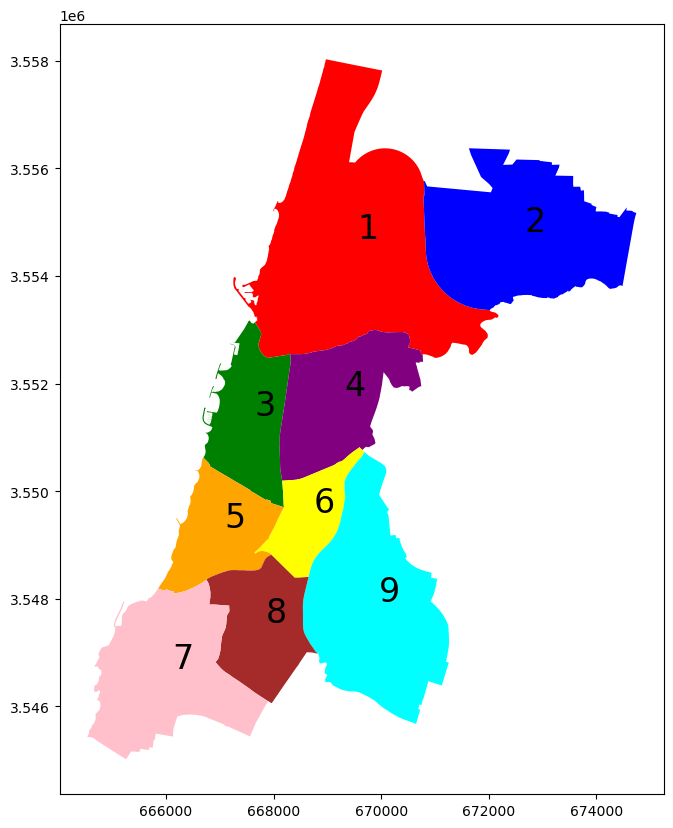

In [3]:
ta_q['index'] = ta_q.index

# Define a list of colors
color_map = {
    1: 'red', 2: 'blue', 3: 'green', 4: 'purple',
    5: 'orange', 6: 'yellow', 7: 'pink', 8: 'brown', 9: 'cyan'
}

# Basic plotting
fig, ax = plt.subplots(figsize=(10, 10))

# Plot each shape with a different color from the list
for idx, row in ta_q.iterrows():
    color = color_map[row['krova']]  # Cycle through the colors list
    gpd.GeoSeries([row['geometry']]).plot(ax=ax, color=color)

    # Get the centroid of the polygon to place the text
    centroid = row['geometry'].centroid
    ax.annotate(text=row['krova'], xy=(centroid.x, centroid.y), 
                xytext=(3, 3), textcoords="offset points",
                fontsize=24, color='black')

plt.show()

In [4]:
# Exclude micro mobility
BICYCLE = 15
SCOOTER = 21
E_BICYCLE = 23
micro_m = [SCOOTER, E_BICYCLE, BICYCLE]


In [5]:
# Load original accident data
i_m_h_ta_gdf = gpd.read_parquet('./csv_tables/i_m_h_ta_gdf.parquet')

In [6]:
# Accidents that are not MM
i_m_h_ta_no_mm_gdf = i_m_h_ta_gdf[~(i_m_h_ta_gdf.involve_vehicle_type.isin(micro_m))].copy()

In [7]:
# Accidents that are just MM
i_m_h_ta_mm_gdf =  gpd.read_parquet('./csv_tables/i_m_h_ta_mm_gdf.parquet')
display(i_m_h_ta_mm_gdf.crs)
i_m_h_ta_mm_gdf.head(5)

<Projected CRS: EPSG:32636>
Name: WGS 84 / UTM zone 36N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 30°E and 36°E, northern hemisphere between equator and 84°N, onshore and offshore. Belarus. Cyprus. Egypt. Ethiopia. Finland. Israel. Jordan. Kenya. Lebanon. Moldova. Norway. Russian Federation. Saudi Arabia. Sudan. Syria. Türkiye (Turkey). Uganda. Ukraine.
- bounds: (30.0, 0.0, 36.0, 84.0)
Coordinate Operation:
- name: UTM zone 36N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

accident_id  provider_and_id  provider_code  file_type_police  \
41    2013001368      32013001368              3                 3   
50    2013001742      32013001742              3                 3   
131   2013001350      12013001350              1                 1   
196   2013000147      12013000147              1                 1   
197   2013000147      12013000147              1                 1   

     involved_type involved_type_hebrew  license_acquiring_date  age_group  \
41               2             נהג נפגע                       0          6   
50               2             נהג נפגע                       0          7   
131              2             נהג נפגע                       0          5   
196              2             נהג נפגע                       0          8   
197              2             נהג נפגע                       0          6   

    age_group_hebrew  sex  ... vehicle_attribution  \
41             25-29    1  ...                 1.0   
50             30-34    2  ...                 1.0   
131            20-24    1  ...                 1.0   
196            35-39    1  ...                 1.0   
197            25-29    1  ...                 1.0   

     vehicle_attribution_hebrew seats  total_weight total_weight_hebrew  \
41                       ישראלי  99.0           0.0             לא ידוע   
50                       ישראלי  99.0           0.0             לא ידוע   
131                      ישראלי  99.0           0.0             לא ידוע   
196                      ישראלי  99.0           0.0             לא ידוע   
197                      ישראלי  99.0           0.0             לא ידוע   

     vehicle_damage vehicle_damage_hebrew  urban_intersection  \
41              4.0               אין נזק                 NaN   
50              4.0               אין נזק                 NaN   
131             4.0               אין נזק                 NaN   
196             2.0                בינוני           9110323.0   
197             2.0                בינוני           9110323.0   

           accident_date                        geometry  
41   2013-07-27 01:00:00  POINT (667544.749 3549959.961)  
50   2013-10-07 01:30:00  POINT (667286.918 3548726.540)  
131  2013-08-25 01:00:00  POINT (667023.688 3548785.170)  
196  2013-09-19 00:00:00  POINT (668158.751 3551284.678)  
197  2013-09-19 00:00:00  POINT (668158.751 3551284.678)  

[5 rows x 162 columns]

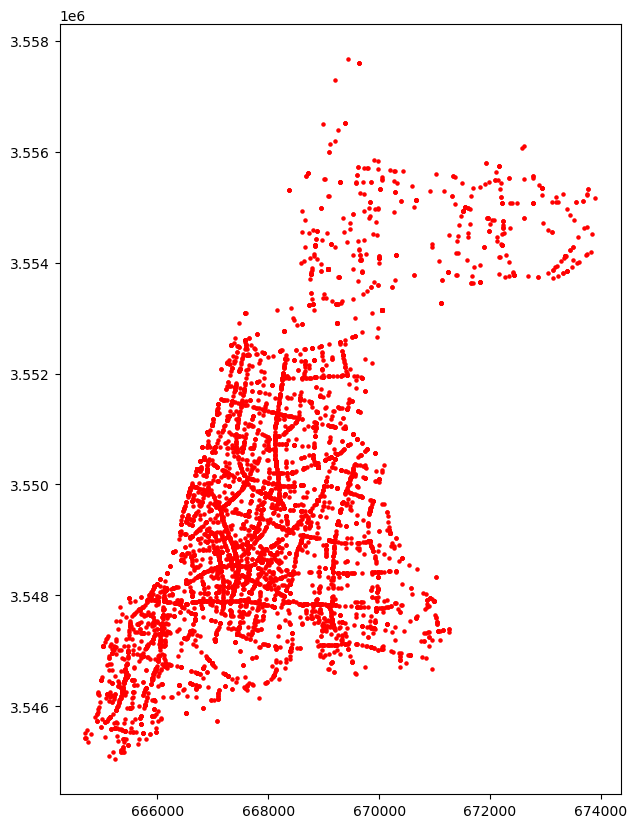

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
i_m_h_ta_mm_gdf.plot(ax=ax, color='red', marker='o', markersize=5 )
plt.show()

In [9]:
bp_ta_bp_and_meta = gpd.read_parquet('./csv_tables/bp_ta_bp_and_meta.parquet')
bp_ta_bp_and_meta.head(5)

oid_shvil  msorech           dateimport  create_year  \
0          1    95.10  14/08/2024 02:30:05         2012   
1          2   201.14  14/08/2024 02:30:05         2013   
2          3   696.31  14/08/2024 02:30:05         2004   
3          4   659.20  14/08/2024 02:30:05         2018   
4          5   362.67  14/08/2024 02:30:05         2018   

                                   shemmikta create_date  \
0                       נמיר מיוניצ'מן דרומה        None   
1                 פרופס מנמיר עד קדושי השואה        None   
2   יאיר רוזנבלום מאורי צבי גרינברג עד פרופס        None   
3                   קק"ל מנמיר עד חיים לבנון        None   
4  רקנאטי בגינה מקרן קיימת לישראל עד אחימאיר        None   

                                            geometry  width direction  bitzua  \
0  LINESTRING (669823.985 3557373.860, 669855.549...    2.5   דו סטרי    2012   
1  LINESTRING (669232.834 3555478.027, 669169.381...    2.5   דו סטרי    2013   
2  LINESTRING (669232.637 3555478.023, 669249.025...    2.1   דו סטרי    2004   
3  LINESTRING (669354.261 3555417.055, 669410.178...    2.5   דו סטרי    2018   
4  LINESTRING (669946.350 3555344.516, 669962.261...    2.0   דו סטרי    2018   

  miflas date_created  
0   None         None  
1   None         None  
2   None         None  
3  מדרכה         None  
4   None   30/06/2018

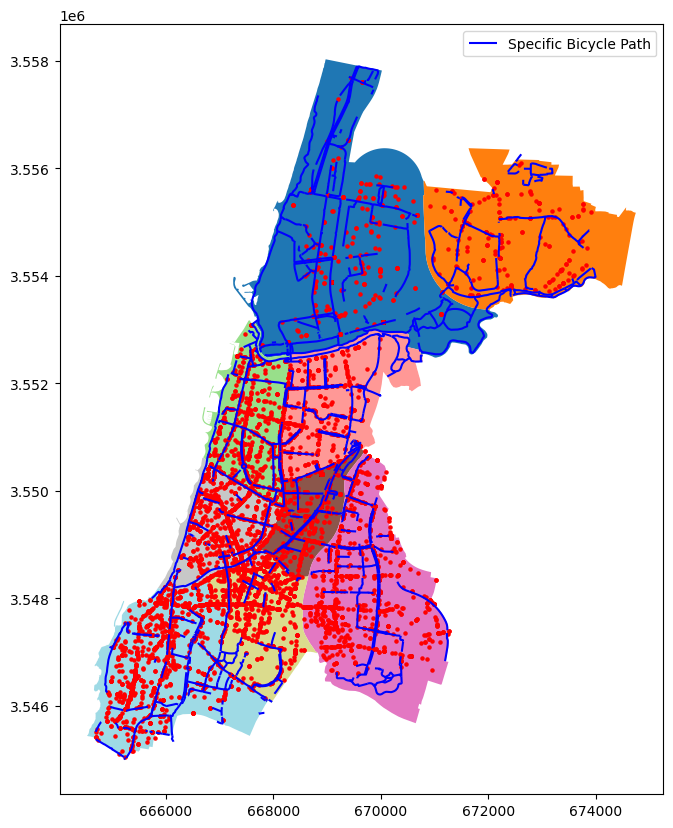

In [10]:
fig, ax = plt.subplots(figsize=(10, 10))

ta_q.plot(ax=ax, cmap='tab20', legend=True,)
bp_ta_bp_and_meta.plot(ax=ax, color='blue', label='Specific Bicycle Path')
i_m_h_ta_mm_gdf.plot(ax=ax, color='red', marker='o', markersize=5 )

plt.legend()
plt.show()

In [11]:
ta_streets = gpd.read_file('./csv_tables/TA_streets_20240724_031704/Streets.shp')
ta_streets

oidrechov  krechov      trechov         shemangli  mslamas  tsug  \
0           1.0    915.0  הרוגי מלכות   HARUGEY MALKHOT    336.0  רחוב   
1           2.0      0.0            0            UKNOWN      0.0  רחוב   
2           3.0    265.0      אמסטרדם         AMSTERDAM    516.0  רחוב   
3           4.0    644.0    אלון יגאל      YIG'AL ALLON   2524.0  רחוב   
4           5.0    634.0      מרגולין          MARGOLIN   2649.0  רחוב   
...         ...      ...          ...               ...      ...   ...   
8874     9851.0   3007.0   שבטי ישראל  SHIVTEY YISRA'EL   1983.0  רחוב   
8875     9852.0   3058.0  אבינרי יצחק           AVINERY   2027.0  רחוב   
8876     9853.0   3058.0  אבינרי יצחק           AVINERY   2027.0  רחוב   
8877     9855.0   3907.0         3907              None   1703.0  רחוב   
8878     9857.0     34.0        מטלון           MATALON   2327.0  רחוב   

      kkivun   UniqueId       shemarvit  kreka  \
0        0.0  507-10001       قتل مملكة  100.0   
1        3.0  507-10002            None  100.0   
2        1.0  507-10003        أمستردام  100.0   
3        0.0  507-10004      ألون ييغال  200.0   
4        1.0  507-10005        مارغولين  100.0   
...      ...        ...             ...    ...   
8874     0.0  507-17843   قبائل إسرائيل  100.0   
8875     0.0  507-20562  Avinri Yitzhak  100.0   
8876     0.0  507-20563  Avinri Yitzhak  100.0   
8877     0.0  507-21960            3907  100.0   
8878     0.0  507-21966         ميتالون  100.0   

                                               geometry  
0     LINESTRING (672865.880 3554095.253, 672895.216...  
1     LINESTRING (666990.498 3551436.940, 667065.337...  
2     LINESTRING (667879.712 3551424.162, 667940.741...  
3     LINESTRING (669570.036 3550420.535, 669581.404...  
4     LINESTRING (669329.153 3548322.758, 669409.403...  
...                                                 ...  
8874  LINESTRING (665771.816 3547023.159, 665760.256...  
8875  LINESTRING (665585.719 3547178.152, 665627.936...  
8876  LINESTRING (665700.142 3547064.296, 665759.119...  
8877  LINESTRING (665087.059 3546677.092, 665075.120...  
8878  LINESTRING (666917.433 3548291.622, 666930.486...  

[8879 rows x 11 columns]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


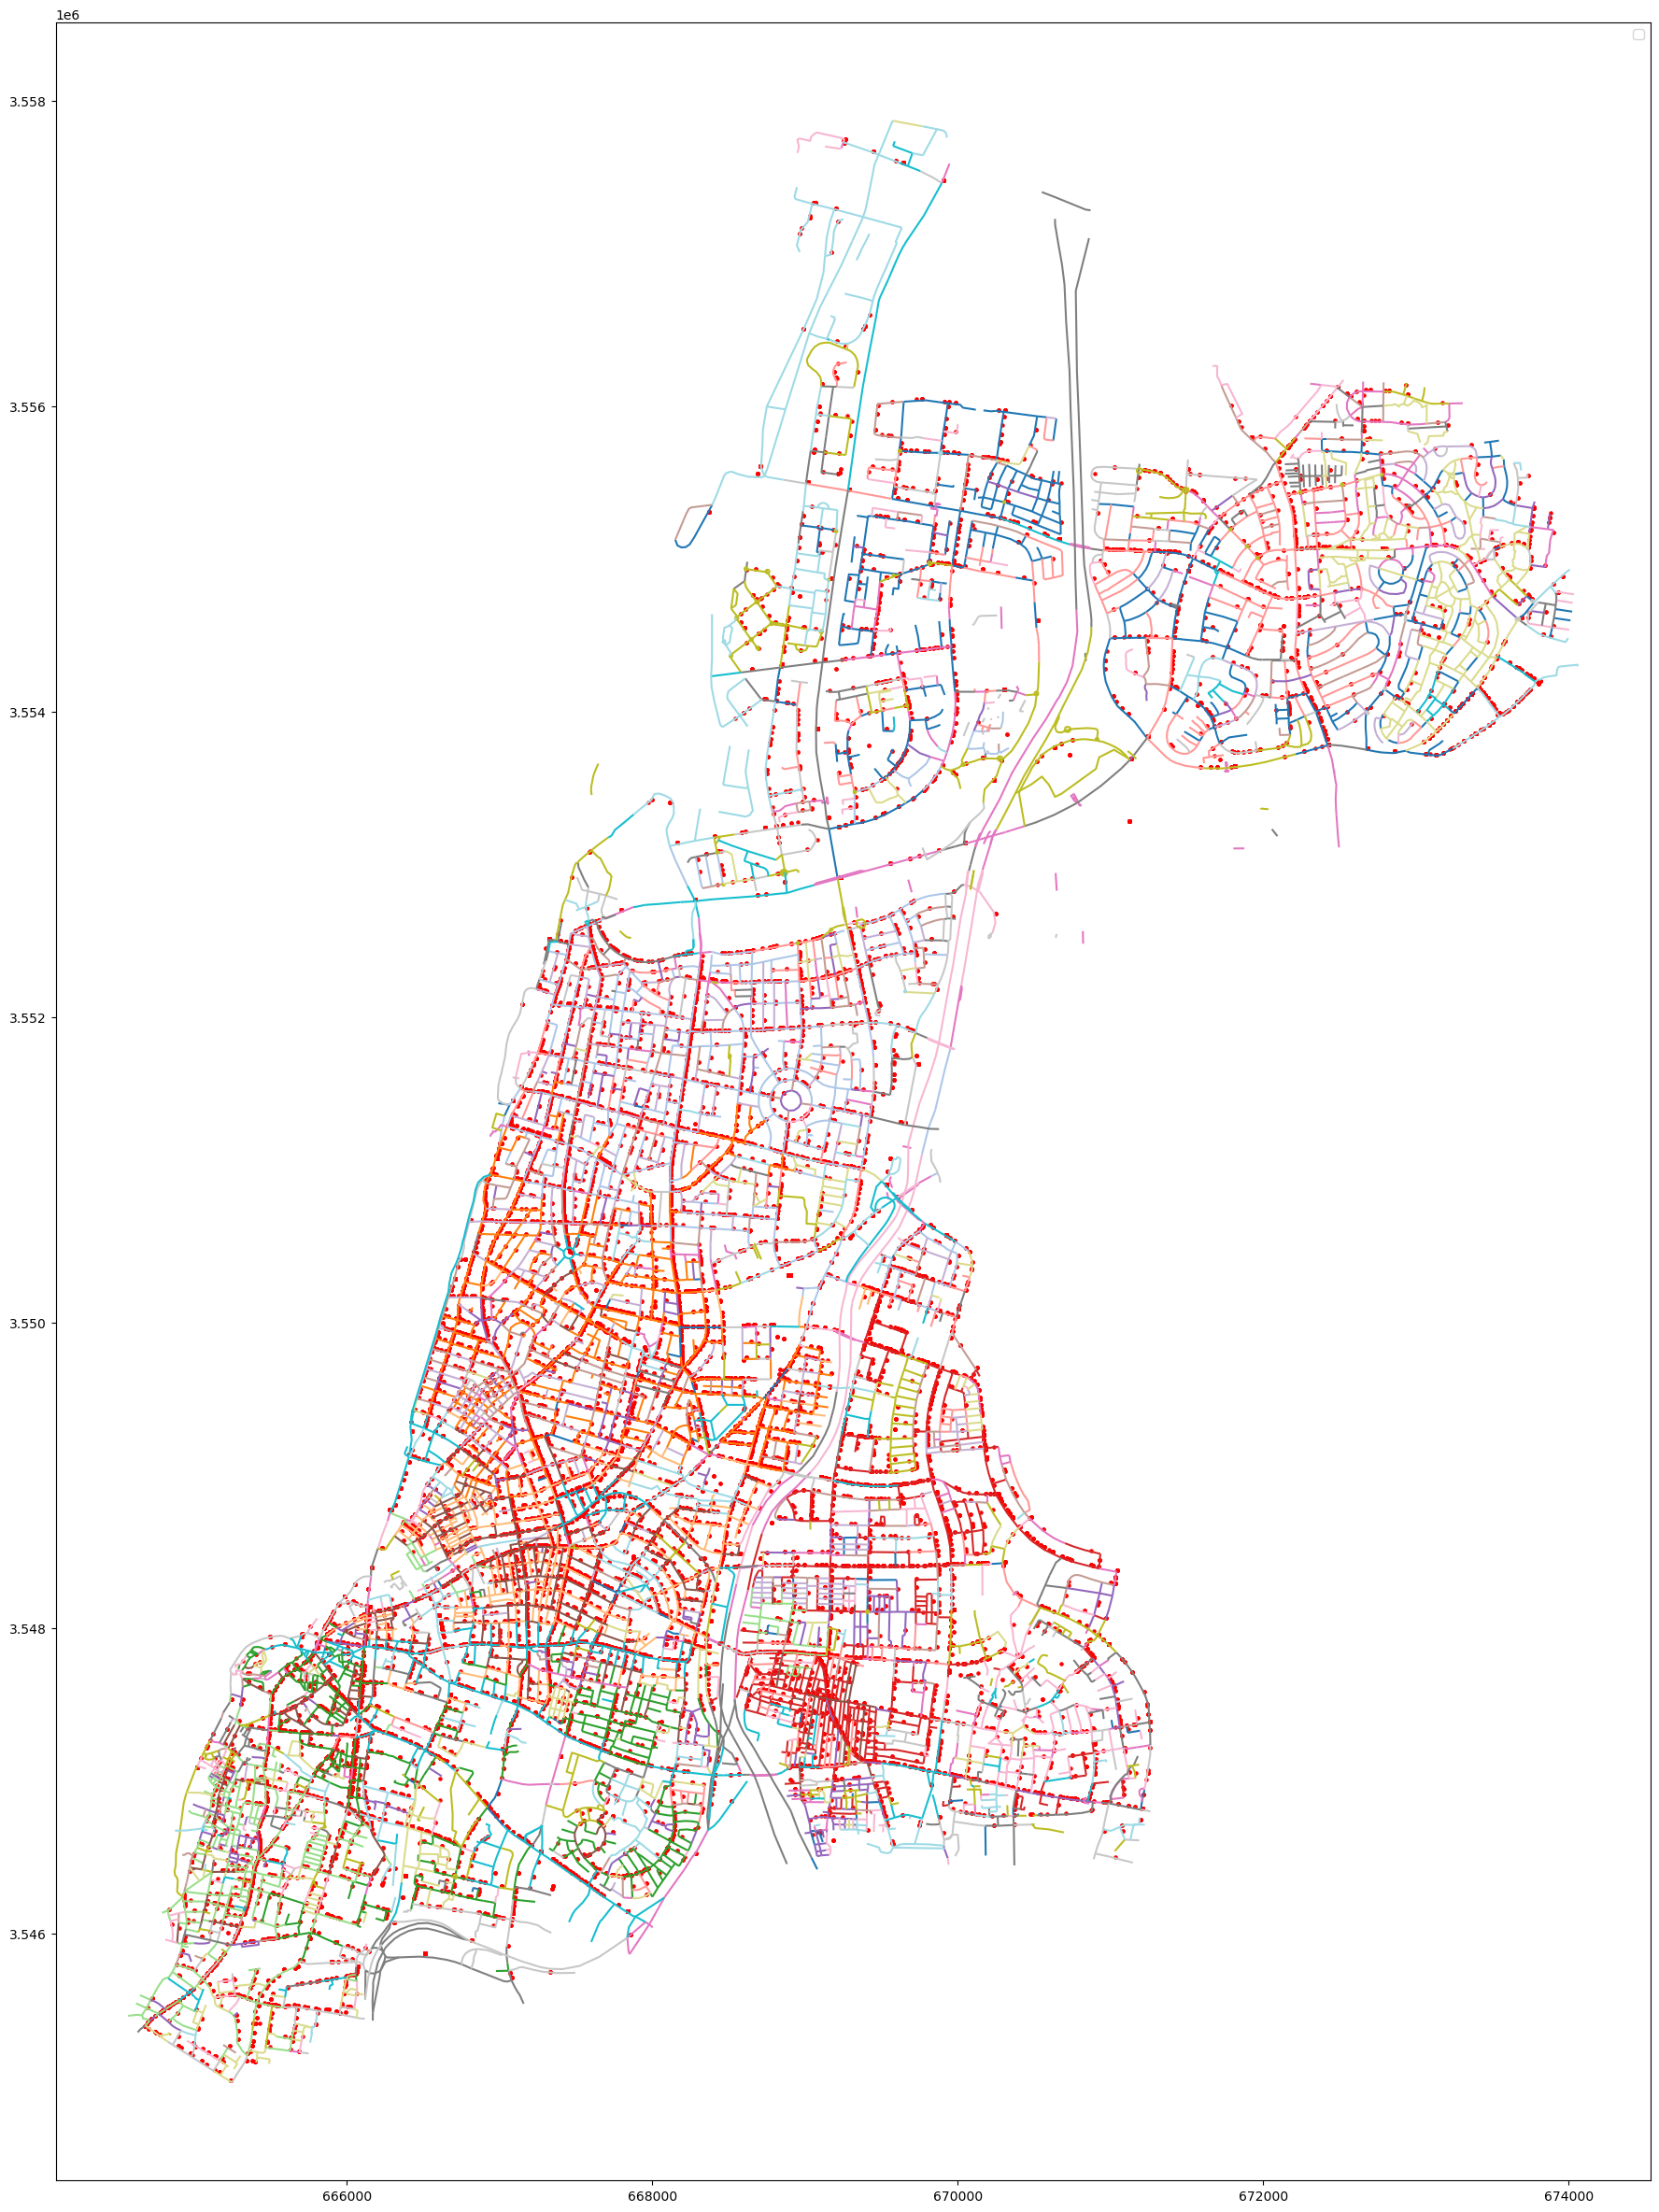

In [12]:

fig, ax = plt.subplots(figsize=(30, 30))
i_m_h_ta_gdf.plot(ax=ax, color='red', marker='o', markersize=5 )
ta_streets.plot(ax=ax, cmap='tab20')
plt.legend()
plt.show()

### Creating Crossroad data

#### Loading crosswalk data:

In [13]:
from shapely.ops import unary_union

In [14]:
# Loading and checking CRS

ta_crossroads = gpd.read_file('./../../Downloads/811/811/811.shp')
print(ta_crossroads.crs)

ta_crossroads = ta_crossroads.to_crs('32636')

ta_crossroads_ = ta_crossroads.copy()
print(ta_crossroads_.crs)

print('shape',ta_crossroads_.shape)

EPSG:2039
EPSG:32636
shape (7637, 11)


In [15]:
ta_crossroads_.head()

traffic_si  traffic__1  traffic_su  last_updat  status_dat  survey_dat  \
0     2040439         811    9.735025  2017-10-01  2017-09-28  2017-09-15   
1     2031701         811    6.523980  2017-10-15  2017-10-04  2017-09-25   
2     2012851         811    3.832506  2017-10-15  2017-10-04  2017-09-20   
3     2009209         811    4.218764  2018-03-06  2017-08-31  2017-08-02   
4     1076995         811    6.469185  2019-01-13  2019-01-10  2019-01-03   

            date_impor  Shape_Leng subject_ch            Descriptio  \
0  15/05/2024 02:28:24   30.000006       None  מעבר חציה להולכי רגל   
1  15/05/2024 02:28:24   20.999978       None  מעבר חציה להולכי רגל   
2  15/05/2024 02:28:24   12.000106       None  מעבר חציה להולכי רגל   
3  15/05/2024 02:28:24   15.000033       None  מעבר חציה להולכי רגל   
4  15/05/2024 02:28:24   21.000049       None  מעבר חציה להולכי רגל   

                                            geometry  
0  MULTILINESTRING ((669691.050 3557664.775, 6696...  
1  MULTILINESTRING ((670184.042 3553411.660, 6701...  
2  MULTILINESTRING ((669406.291 3552768.178, 6694...  
3  MULTILINESTRING ((669634.554 3555705.217, 6696...  
4  MULTILINESTRING ((665268.696 3545605.810, 6652...

Plotting Crosswalks

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


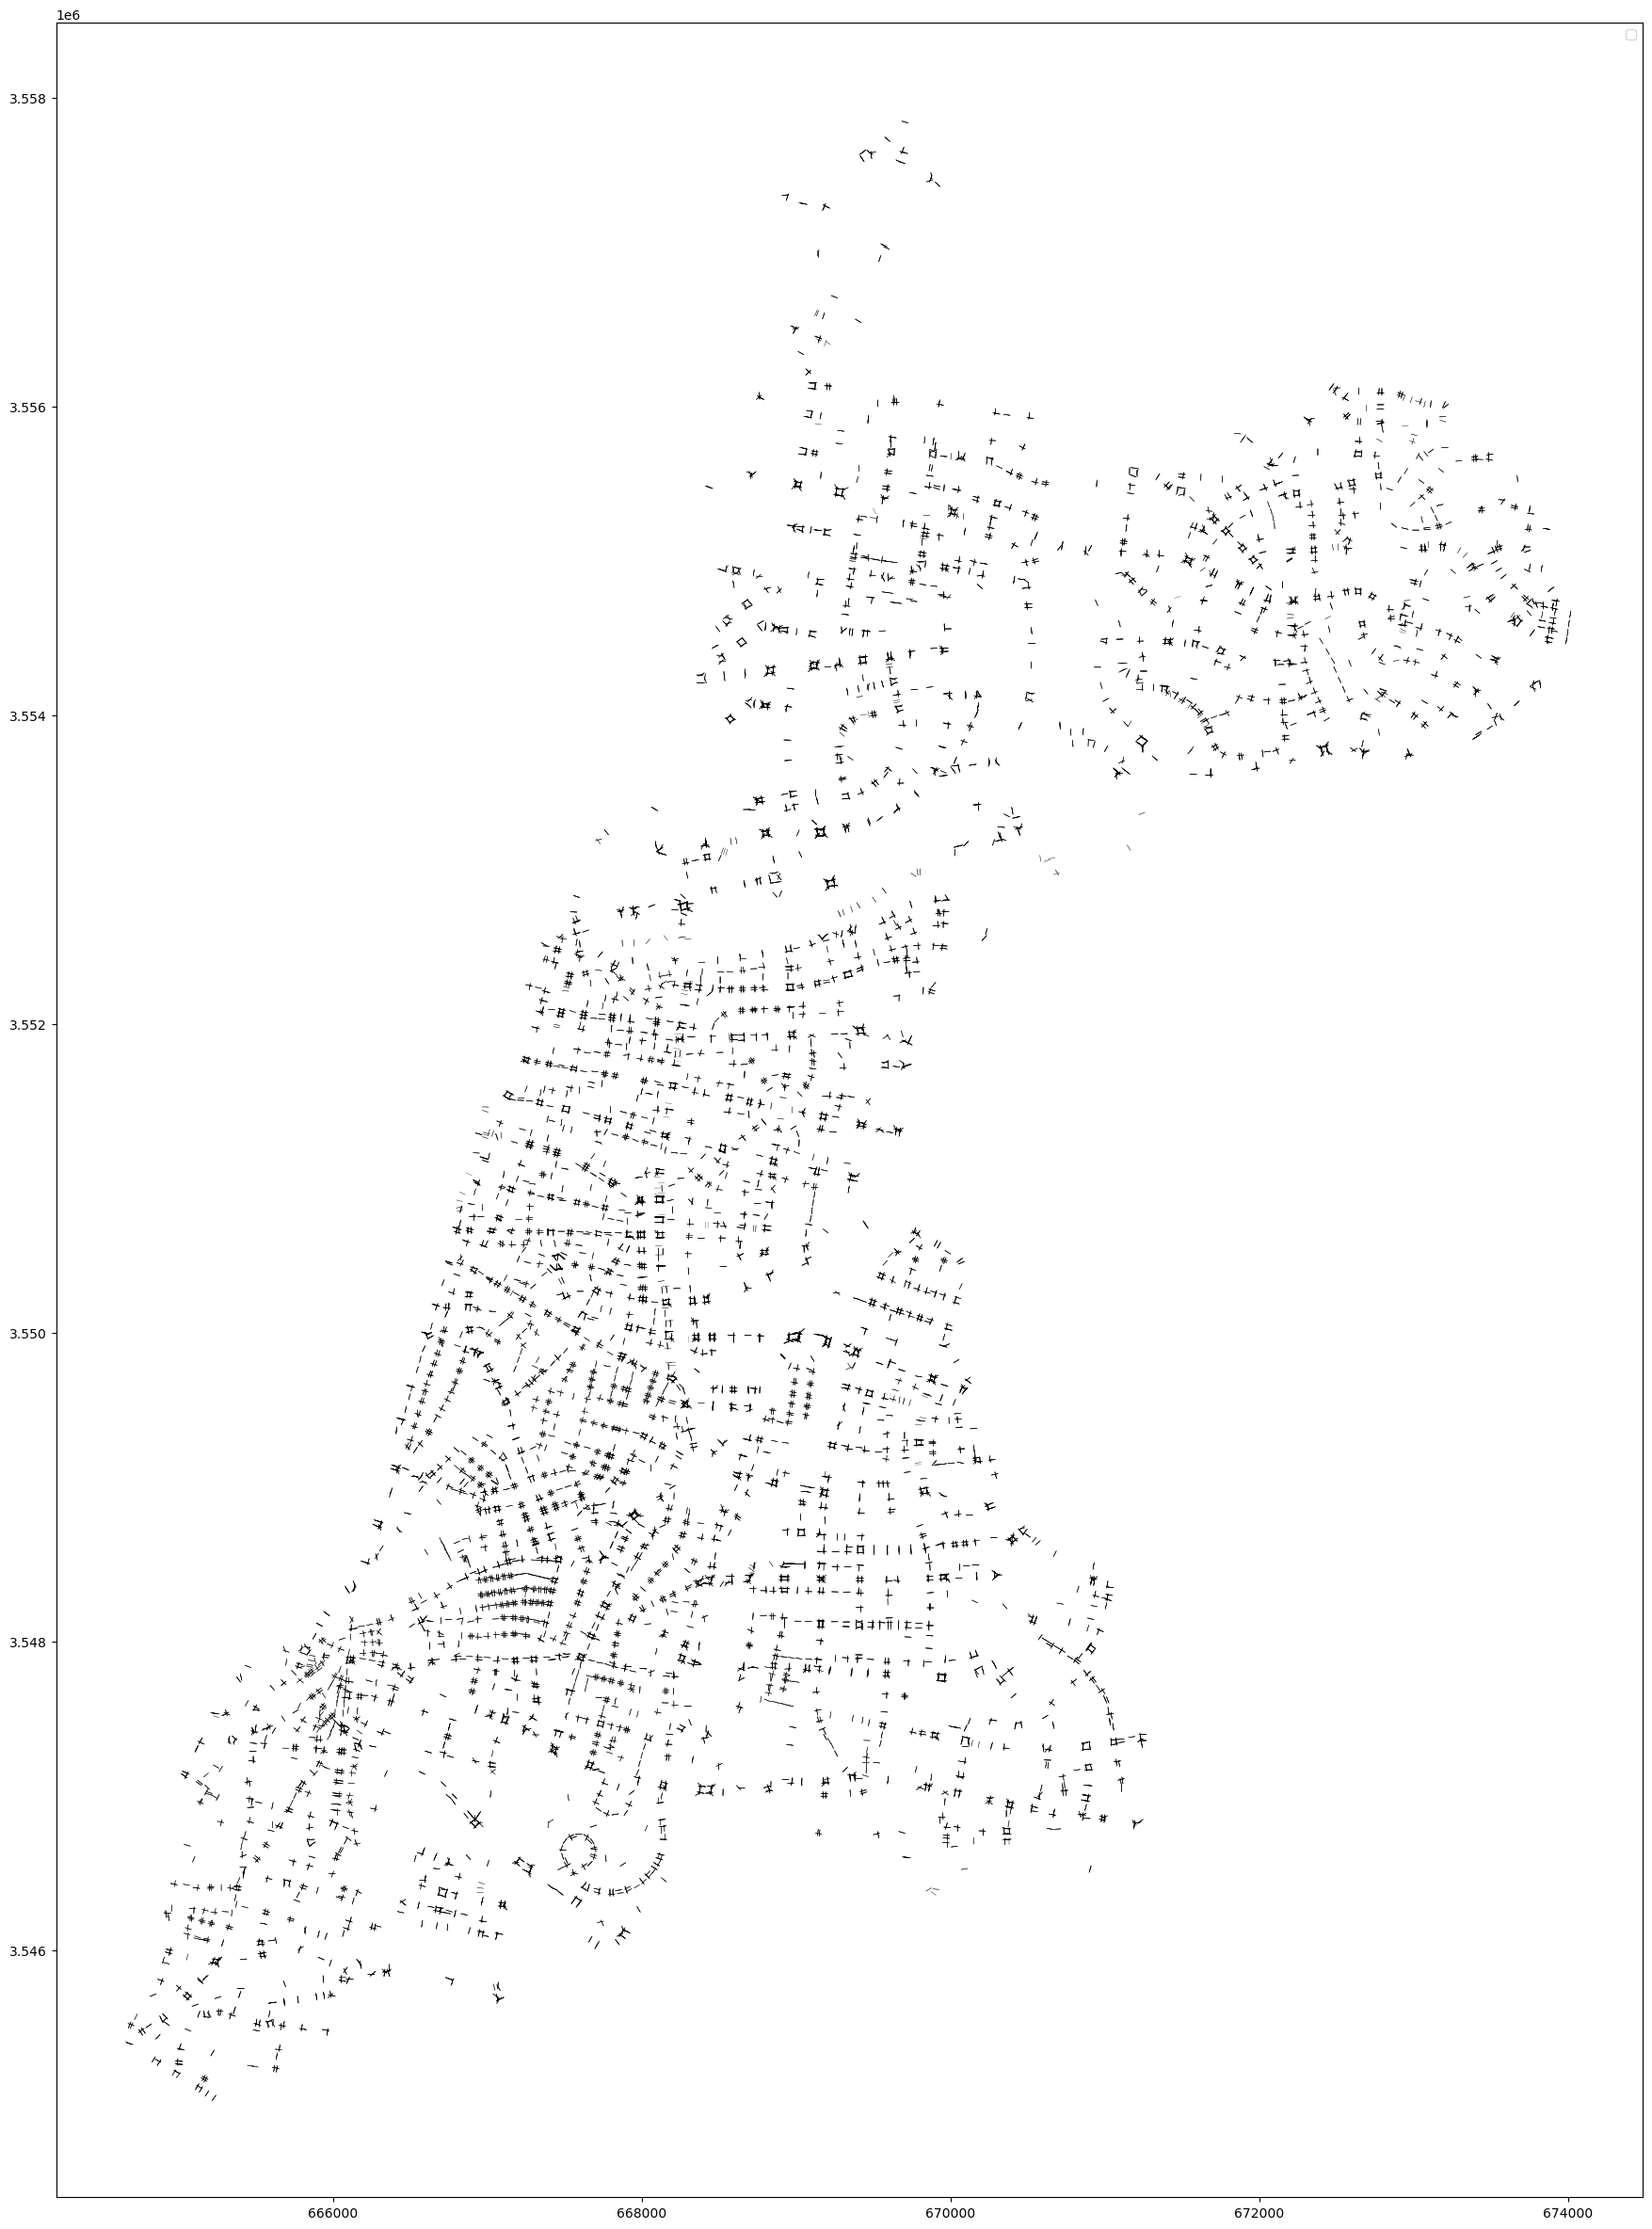

In [16]:
fig, ax = plt.subplots(figsize=(30, 30))
ta_crossroads_.plot(ax=ax, color='black', linewidth=5, alpha=0.5)

plt.legend()
plt.show()

Plotting specific crosswalks that I found in later exploration.

1065, 1058, 1430, 1709, 962, 1464, 874, 1384, 685, 965

In [17]:
specific_crosswalks = [1065]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


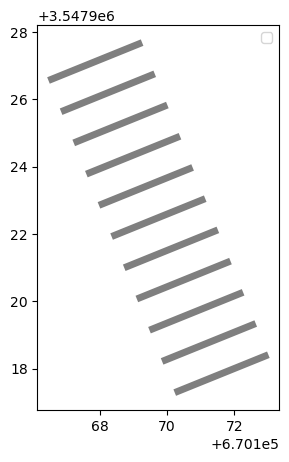

In [18]:
fig, ax = plt.subplots(figsize=(5, 5))
ta_crossroads[ta_crossroads.index.isin(specific_crosswalks)].plot(ax=ax, color='black', linewidth=5, alpha=0.5)

plt.legend()
plt.show()

Converting multi string crosswalk to a polygon and then combining different crosswalks that are at proximity to become a single polygon hence a crossroad

In [19]:
# Buffer each geometry and create convex hull if needed
ta_crossroads_['geometry'] = ta_crossroads_.geometry.convex_hull.buffer(10)  # Adjust buffer size

# Combine all geometries into a single multipolygon with merged overlaps
# This step will merge any overlapping polygons into a single geometry
merged_geometry = unary_union(ta_crossroads_.geometry)

# If you want each connected component as a separate polygon, convert the multipolygon back to individual polygons
crossroads_poly = gpd.GeoDataFrame(geometry=[merged_geometry], crs=ta_crossroads_.crs)

# Explode into individual polygons if merged into a MultiPolygon
crossroads_poly = crossroads_poly.explode(index_parts=True).reset_index(drop=True)

In [20]:
crossroads_poly

geometry
0     POLYGON ((665236.305 3545032.614, 665235.706 3...
1     POLYGON ((665191.334 3545061.628, 665190.763 3...
2     POLYGON ((665152.023 3545087.512, 665151.480 3...
3     POLYGON ((665169.380 3545149.282, 665169.097 3...
4     POLYGON ((665005.047 3545179.336, 665004.391 3...
...                                                 ...
2909  POLYGON ((666639.398 3549715.946, 666638.841 3...
2910  POLYGON ((667951.101 3549721.718, 667950.866 3...
2911  POLYGON ((668095.419 3549718.909, 668095.180 3...
2912  POLYGON ((667358.461 3549733.296, 667357.698 3...
2913  POLYGON ((667695.956 3549731.804, 667695.914 3...

[2914 rows x 1 columns]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


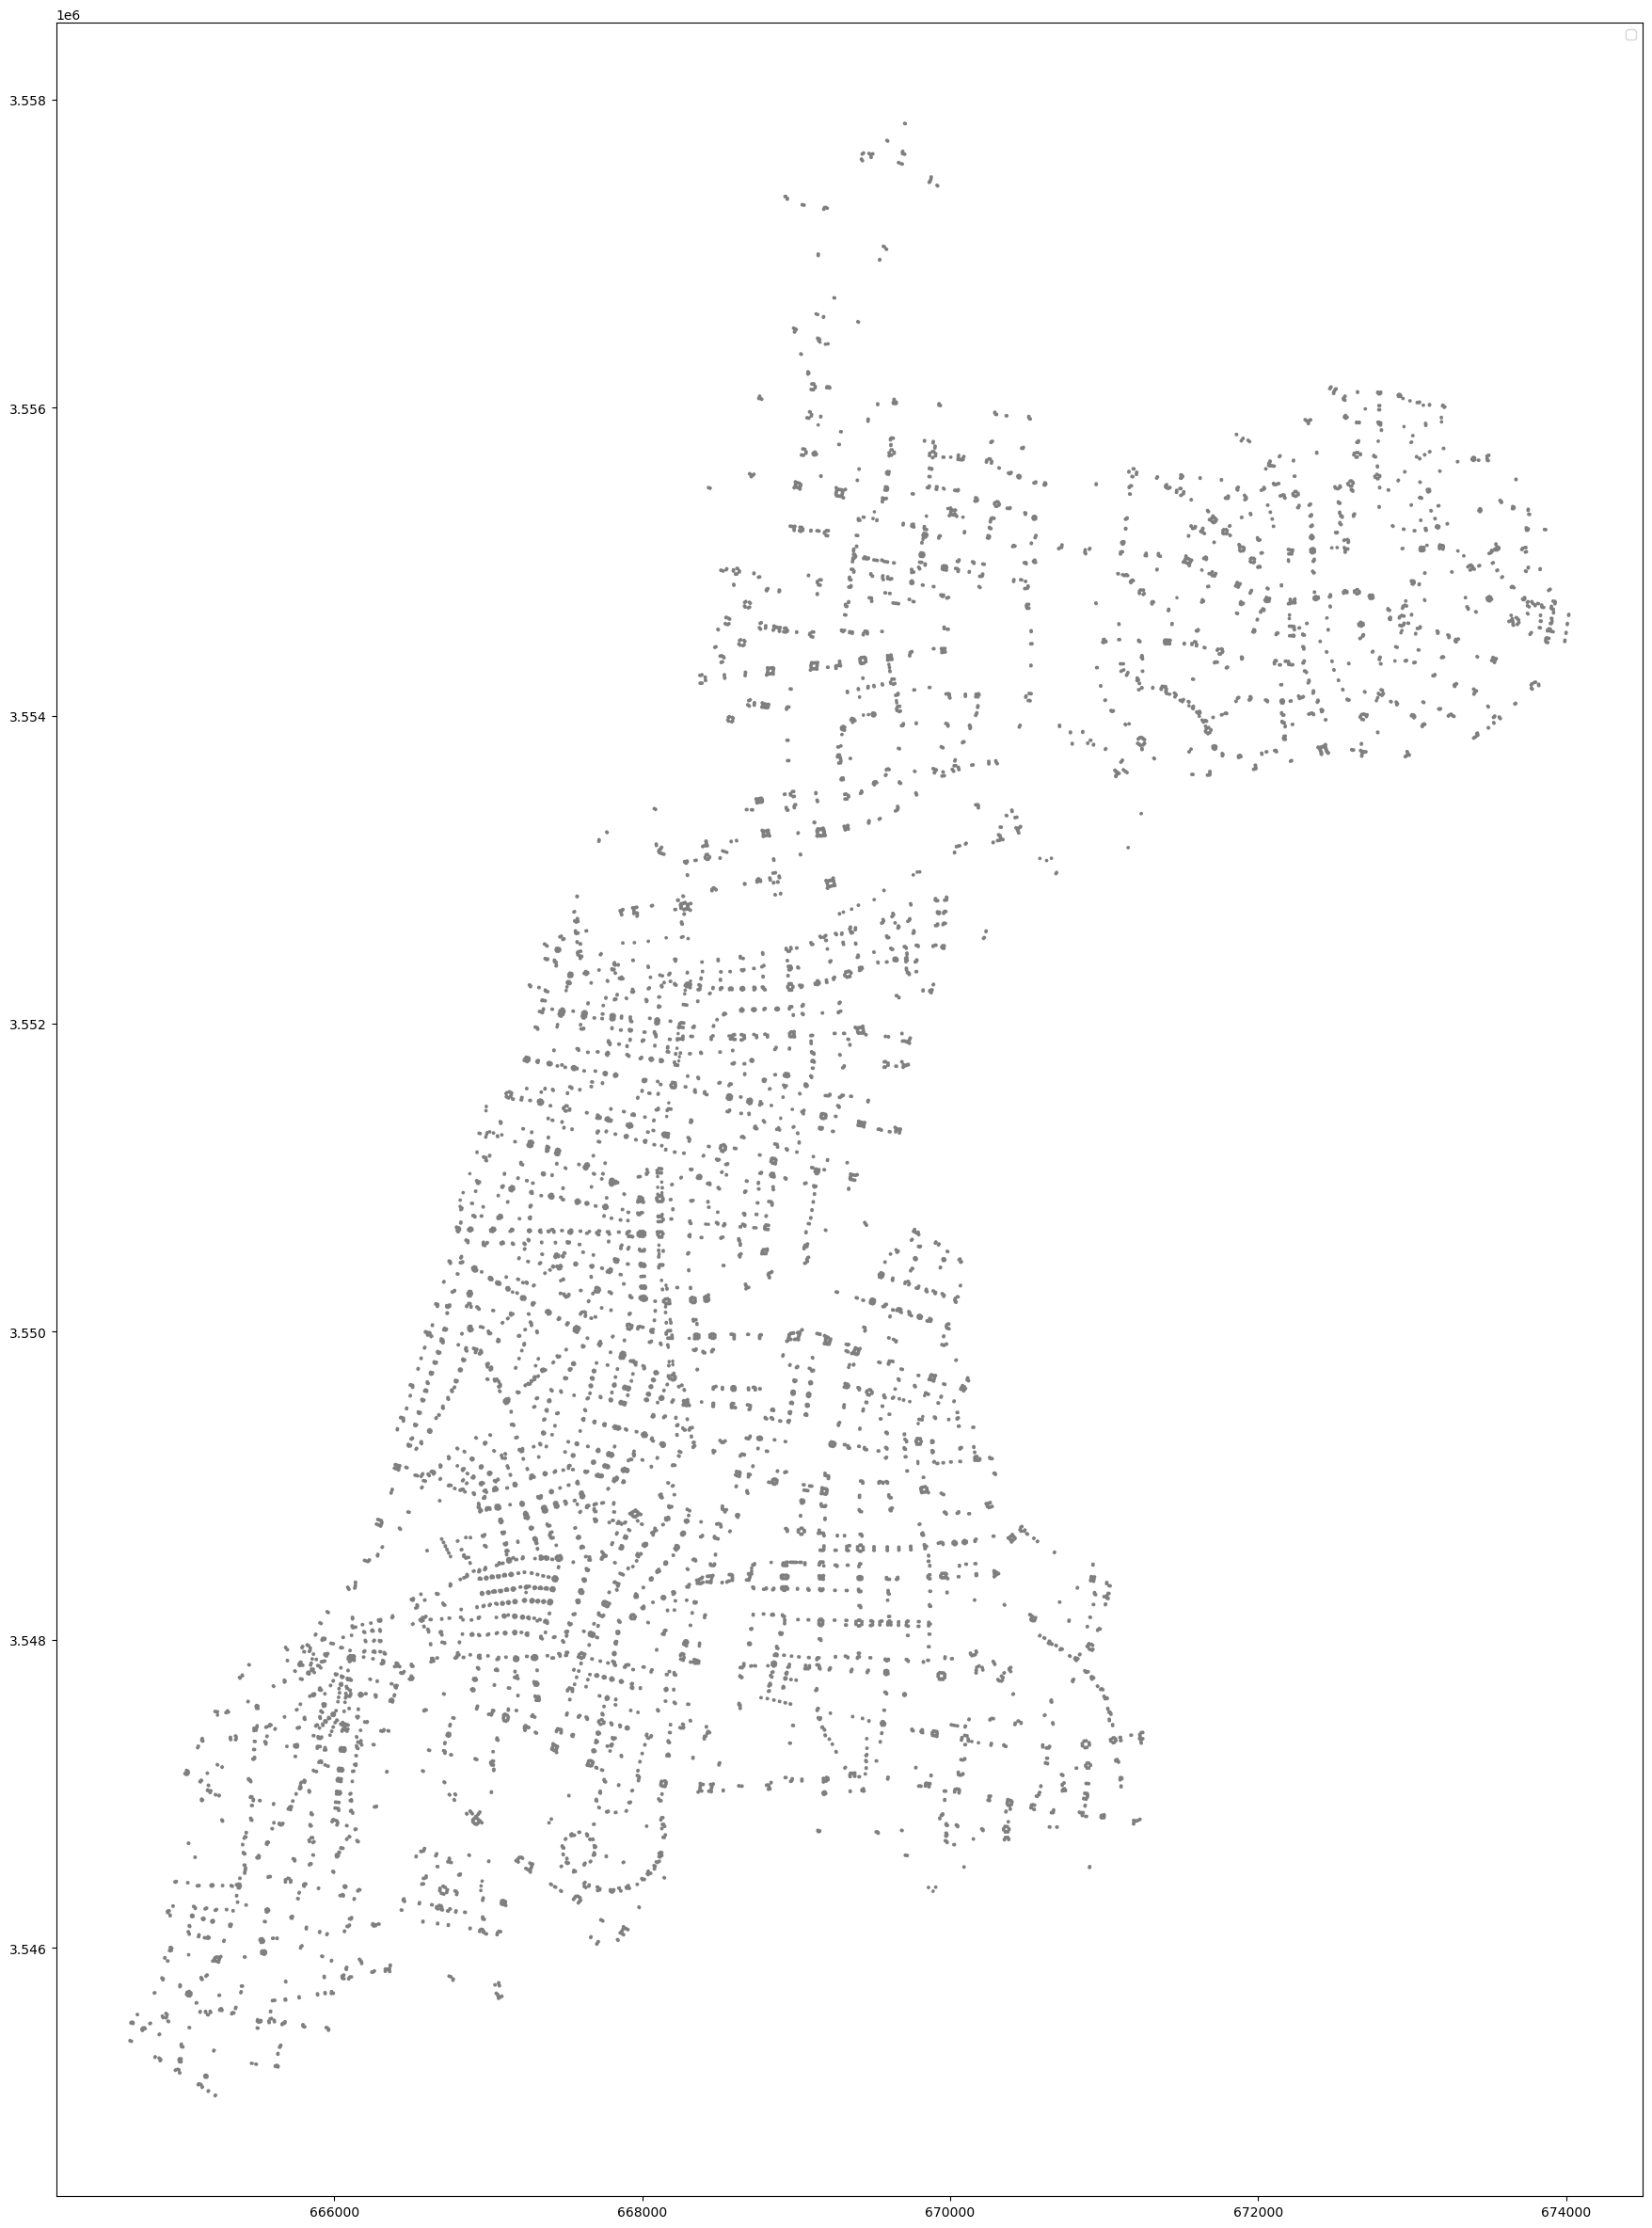

In [21]:
fig, ax = plt.subplots(figsize=(30, 30))
crossroads_poly.plot(ax=ax, color='black', linewidth=5, alpha=0.5)

plt.legend()
plt.show()

Plotting the specific crosswalk after preforming the conversion.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


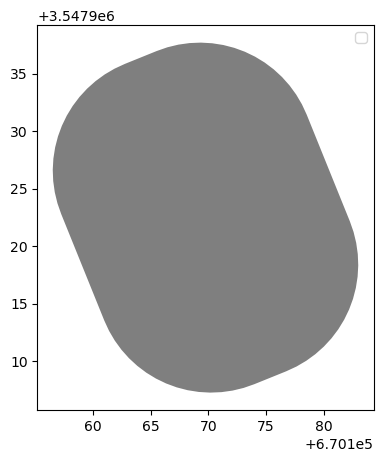

In [22]:
fig, ax = plt.subplots(figsize=(5, 5))
ta_crossroads_[ta_crossroads_.index.isin(specific_crosswalks)].plot(ax=ax, color='black', linewidth=5, alpha=0.5)

plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


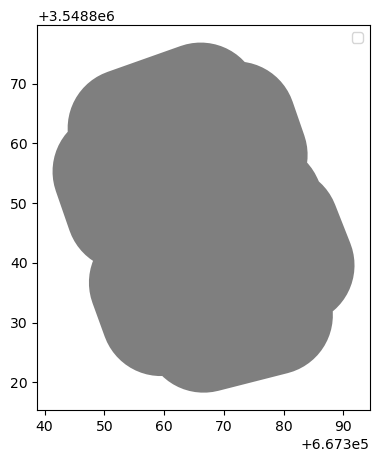

In [23]:
fig, ax = plt.subplots(figsize=(5, 5))
crossroads_poly[crossroads_poly.index.isin(specific_crosswalks)].plot(ax=ax, color='black', linewidth=5, alpha=0.5)

plt.legend()
plt.show()

#### Get the accidents that intersect the crosswalks

In [24]:
i_m_h_ta_mm_gdf.shape

(8789, 162)

Removing participants in the same accidents so we don't have more accidents.

Later we will analyze all participants when we want to check severity.

In [25]:
i_m_h_ta_mm_gdf_ = i_m_h_ta_mm_gdf.drop_duplicates(subset=['provider_and_id'])
i_m_h_ta_mm_gdf_ = i_m_h_ta_mm_gdf_[i_m_h_ta_mm_gdf_.location_accuracy == 1]

i_m_h_ta_mm_gdf_.shape

(4997, 162)

Getting the accidents that intersect our created crossroads.

In [26]:
i_m_h_ta_mm_crossroads_gdf = gpd.sjoin(i_m_h_ta_mm_gdf_, crossroads_poly, how='inner', predicate='intersects')

In [27]:
i_m_h_ta_mm_crossroads_gdf_ = i_m_h_ta_mm_crossroads_gdf.drop_duplicates(subset=['provider_and_id'])
i_m_h_ta_mm_crossroads_gdf_

accident_id  provider_and_id  provider_code  file_type_police  \
196      2013000147      12013000147              1                 1   
251      2013001755      32013001755              3                 3   
257      2013002105      32013002105              3                 3   
349      2013001346      32013001346              3                 3   
455      2013002036      12013002036              1                 1   
...             ...              ...            ...               ...   
111269   2024098273      32024098273              3                 3   
111326   2024098833      32024098833              3                 3   
111332   2024090432      12024090432              1                 1   
111345   2024096932      32024096932              3                 3   
111394   2024095204      32024095204              3                 3   

        involved_type involved_type_hebrew  license_acquiring_date  age_group  \
196                 2             נהג נפגע                       0          8   
251                 2             נהג נפגע                    2005          6   
257                 1                  נהג                       0          7   
349                 2             נהג נפגע                       0          5   
455                 2             נהג נפגע                       0          6   
...               ...                  ...                     ...        ...   
111269              2             נהג נפגע                    1980         13   
111326              1                  נהג                       0         99   
111332              2             נהג נפגע                    1996         10   
111345              2             נהג נפגע                    2023          4   
111394              2             נהג נפגע                    2013          7   

       age_group_hebrew  sex  ... vehicle_attribution_hebrew  seats  \
196               35-39    1  ...                     ישראלי   99.0   
251               25-29    1  ...                     ישראלי   99.0   
257               30-34    1  ...                     ישראלי   99.0   
349               20-24    2  ...                     ישראלי   99.0   
455               25-29    2  ...                     ישראלי   99.0   
...                 ...  ...  ...                        ...    ...   
111269            60-64    1  ...                     ישראלי   99.0   
111326          לא ידוע    0  ...                     ישראלי   99.0   
111332            45-49    2  ...                     ישראלי   99.0   
111345            15-19    1  ...                     ישראלי   99.0   
111394            30-34    1  ...                     ישראלי   99.0   

       total_weight  total_weight_hebrew vehicle_damage  \
196             0.0              לא ידוע            2.0   
251             0.0              לא ידוע            4.0   
257             0.0              לא ידוע            1.0   
349             0.0              לא ידוע            4.0   
455             0.0              לא ידוע            4.0   
...             ...                  ...            ...   
111269          0.0              לא ידוע            1.0   
111326          0.0              לא ידוע            4.0   
111332          0.0              לא ידוע            1.0   
111345          0.0              לא ידוע            4.0   
111394          0.0              לא ידוע            4.0   

        vehicle_damage_hebrew urban_intersection        accident_date  \
196                    בינוני          9110323.0  2013-09-19 00:00:00   
251                   אין נזק         11670545.0  2013-11-23 01:30:00   
257                        קל          7540321.0  2013-01-01 02:15:00   
349                   אין נזק            10335.0  2013-09-06 01:00:00   
455                   אין נזק          7190312.0  2013-07-25 02:00:00   
...                       ...                ...                  ...   
111269                     קל         15270924.0  2024-03-31 08:00:00   
111326      

In [28]:
i_m_h_ta_mm_crossroads_gdf_.value_counts(subset='index_right')

index_right
1065    32
1058    30
1430    21
1709    19
962     18
        ..
1201     1
1196     1
1193     1
1192     1
0        1
Name: count, Length: 749, dtype: int64

### Creating crossroad name

I have tried using i_m_h_ta_mm_crossroads_gdf street1_hebrew and street2_hebrew to create the crossroad name.<br>
But there are cases where there is only 1 street1_hebrew and nan street2_hebrew so the result is nan<br>
OR there are several streets connecting and each accidents has a different street1_hebrew name 4 times for the same crossroad.

Will try to get the name by sjoin on ta_streets.

In [29]:
crossroads_poly

geometry
0     POLYGON ((665236.305 3545032.614, 665235.706 3...
1     POLYGON ((665191.334 3545061.628, 665190.763 3...
2     POLYGON ((665152.023 3545087.512, 665151.480 3...
3     POLYGON ((665169.380 3545149.282, 665169.097 3...
4     POLYGON ((665005.047 3545179.336, 665004.391 3...
...                                                 ...
2909  POLYGON ((666639.398 3549715.946, 666638.841 3...
2910  POLYGON ((667951.101 3549721.718, 667950.866 3...
2911  POLYGON ((668095.419 3549718.909, 668095.180 3...
2912  POLYGON ((667358.461 3549733.296, 667357.698 3...
2913  POLYGON ((667695.956 3549731.804, 667695.914 3...

[2914 rows x 1 columns]

In [30]:
ta_streets

oidrechov  krechov      trechov         shemangli  mslamas  tsug  \
0           1.0    915.0  הרוגי מלכות   HARUGEY MALKHOT    336.0  רחוב   
1           2.0      0.0            0            UKNOWN      0.0  רחוב   
2           3.0    265.0      אמסטרדם         AMSTERDAM    516.0  רחוב   
3           4.0    644.0    אלון יגאל      YIG'AL ALLON   2524.0  רחוב   
4           5.0    634.0      מרגולין          MARGOLIN   2649.0  רחוב   
...         ...      ...          ...               ...      ...   ...   
8874     9851.0   3007.0   שבטי ישראל  SHIVTEY YISRA'EL   1983.0  רחוב   
8875     9852.0   3058.0  אבינרי יצחק           AVINERY   2027.0  רחוב   
8876     9853.0   3058.0  אבינרי יצחק           AVINERY   2027.0  רחוב   
8877     9855.0   3907.0         3907              None   1703.0  רחוב   
8878     9857.0     34.0        מטלון           MATALON   2327.0  רחוב   

      kkivun   UniqueId       shemarvit  kreka  \
0        0.0  507-10001       قتل مملكة  100.0   
1        3.0  507-10002            None  100.0   
2        1.0  507-10003        أمستردام  100.0   
3        0.0  507-10004      ألون ييغال  200.0   
4        1.0  507-10005        مارغولين  100.0   
...      ...        ...             ...    ...   
8874     0.0  507-17843   قبائل إسرائيل  100.0   
8875     0.0  507-20562  Avinri Yitzhak  100.0   
8876     0.0  507-20563  Avinri Yitzhak  100.0   
8877     0.0  507-21960            3907  100.0   
8878     0.0  507-21966         ميتالون  100.0   

                                               geometry  
0     LINESTRING (672865.880 3554095.253, 672895.216...  
1     LINESTRING (666990.498 3551436.940, 667065.337...  
2     LINESTRING (667879.712 3551424.162, 667940.741...  
3     LINESTRING (669570.036 3550420.535, 669581.404...  
4     LINESTRING (669329.153 3548322.758, 669409.403...  
...                                                 ...  
8874  LINESTRING (665771.816 3547023.159, 665760.256...  
8875  LINESTRING (665585.719 3547178.152, 665627.936...  
8876  LINESTRING (665700.142 3547064.296, 665759.119...  
8877  LINESTRING (665087.059 3546677.092, 665075.120...  
8878  LINESTRING (666917.433 3548291.622, 666930.486...  

[8879 rows x 11 columns]

In [31]:
crossroads_poly

geometry
0     POLYGON ((665236.305 3545032.614, 665235.706 3...
1     POLYGON ((665191.334 3545061.628, 665190.763 3...
2     POLYGON ((665152.023 3545087.512, 665151.480 3...
3     POLYGON ((665169.380 3545149.282, 665169.097 3...
4     POLYGON ((665005.047 3545179.336, 665004.391 3...
...                                                 ...
2909  POLYGON ((666639.398 3549715.946, 666638.841 3...
2910  POLYGON ((667951.101 3549721.718, 667950.866 3...
2911  POLYGON ((668095.419 3549718.909, 668095.180 3...
2912  POLYGON ((667358.461 3549733.296, 667357.698 3...
2913  POLYGON ((667695.956 3549731.804, 667695.914 3...

[2914 rows x 1 columns]

In [32]:
crossroads_index = crossroads_poly.index
crossroads_index

RangeIndex(start=0, stop=2914, step=1)

In [33]:
ta_street_crossroads = gpd.sjoin(ta_streets,crossroads_poly)

# ta_street_crossroads = ta_street_crossroads.drop_duplicates('krechov')
# ta_street_crossroads

In [34]:
# checking discrepancy between crossroads_poly and ta_streets join

ta_street_crossroads.index_right.values

array([2344, 2353, 1841, ...,  312,  197,  832], dtype=int64)

In [35]:
# Convert RangeIndex to a set
range_set = set(crossroads_index)

# Convert the array to a set
array_set = set(ta_street_crossroads.index_right.values)

# Find the intersection
intersection = crossroads_index.intersection(array_set)

# Find the values in the RangeIndex that are not in the array
difference = crossroads_index.difference(array_set)

# Convert results to sorted lists if needed
intersection_list = sorted(intersection)
difference_list = sorted(difference)

# Print results
print("Intersection:", intersection_list)
print("Difference:", difference_list)

Intersection: [0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 71, 72, 74, 75, 76, 77, 78, 79, 80, 81, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 128, 129, 130, 131, 132, 133, 135, 136, 138, 139, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230,

In [36]:
len(difference_list)

148

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


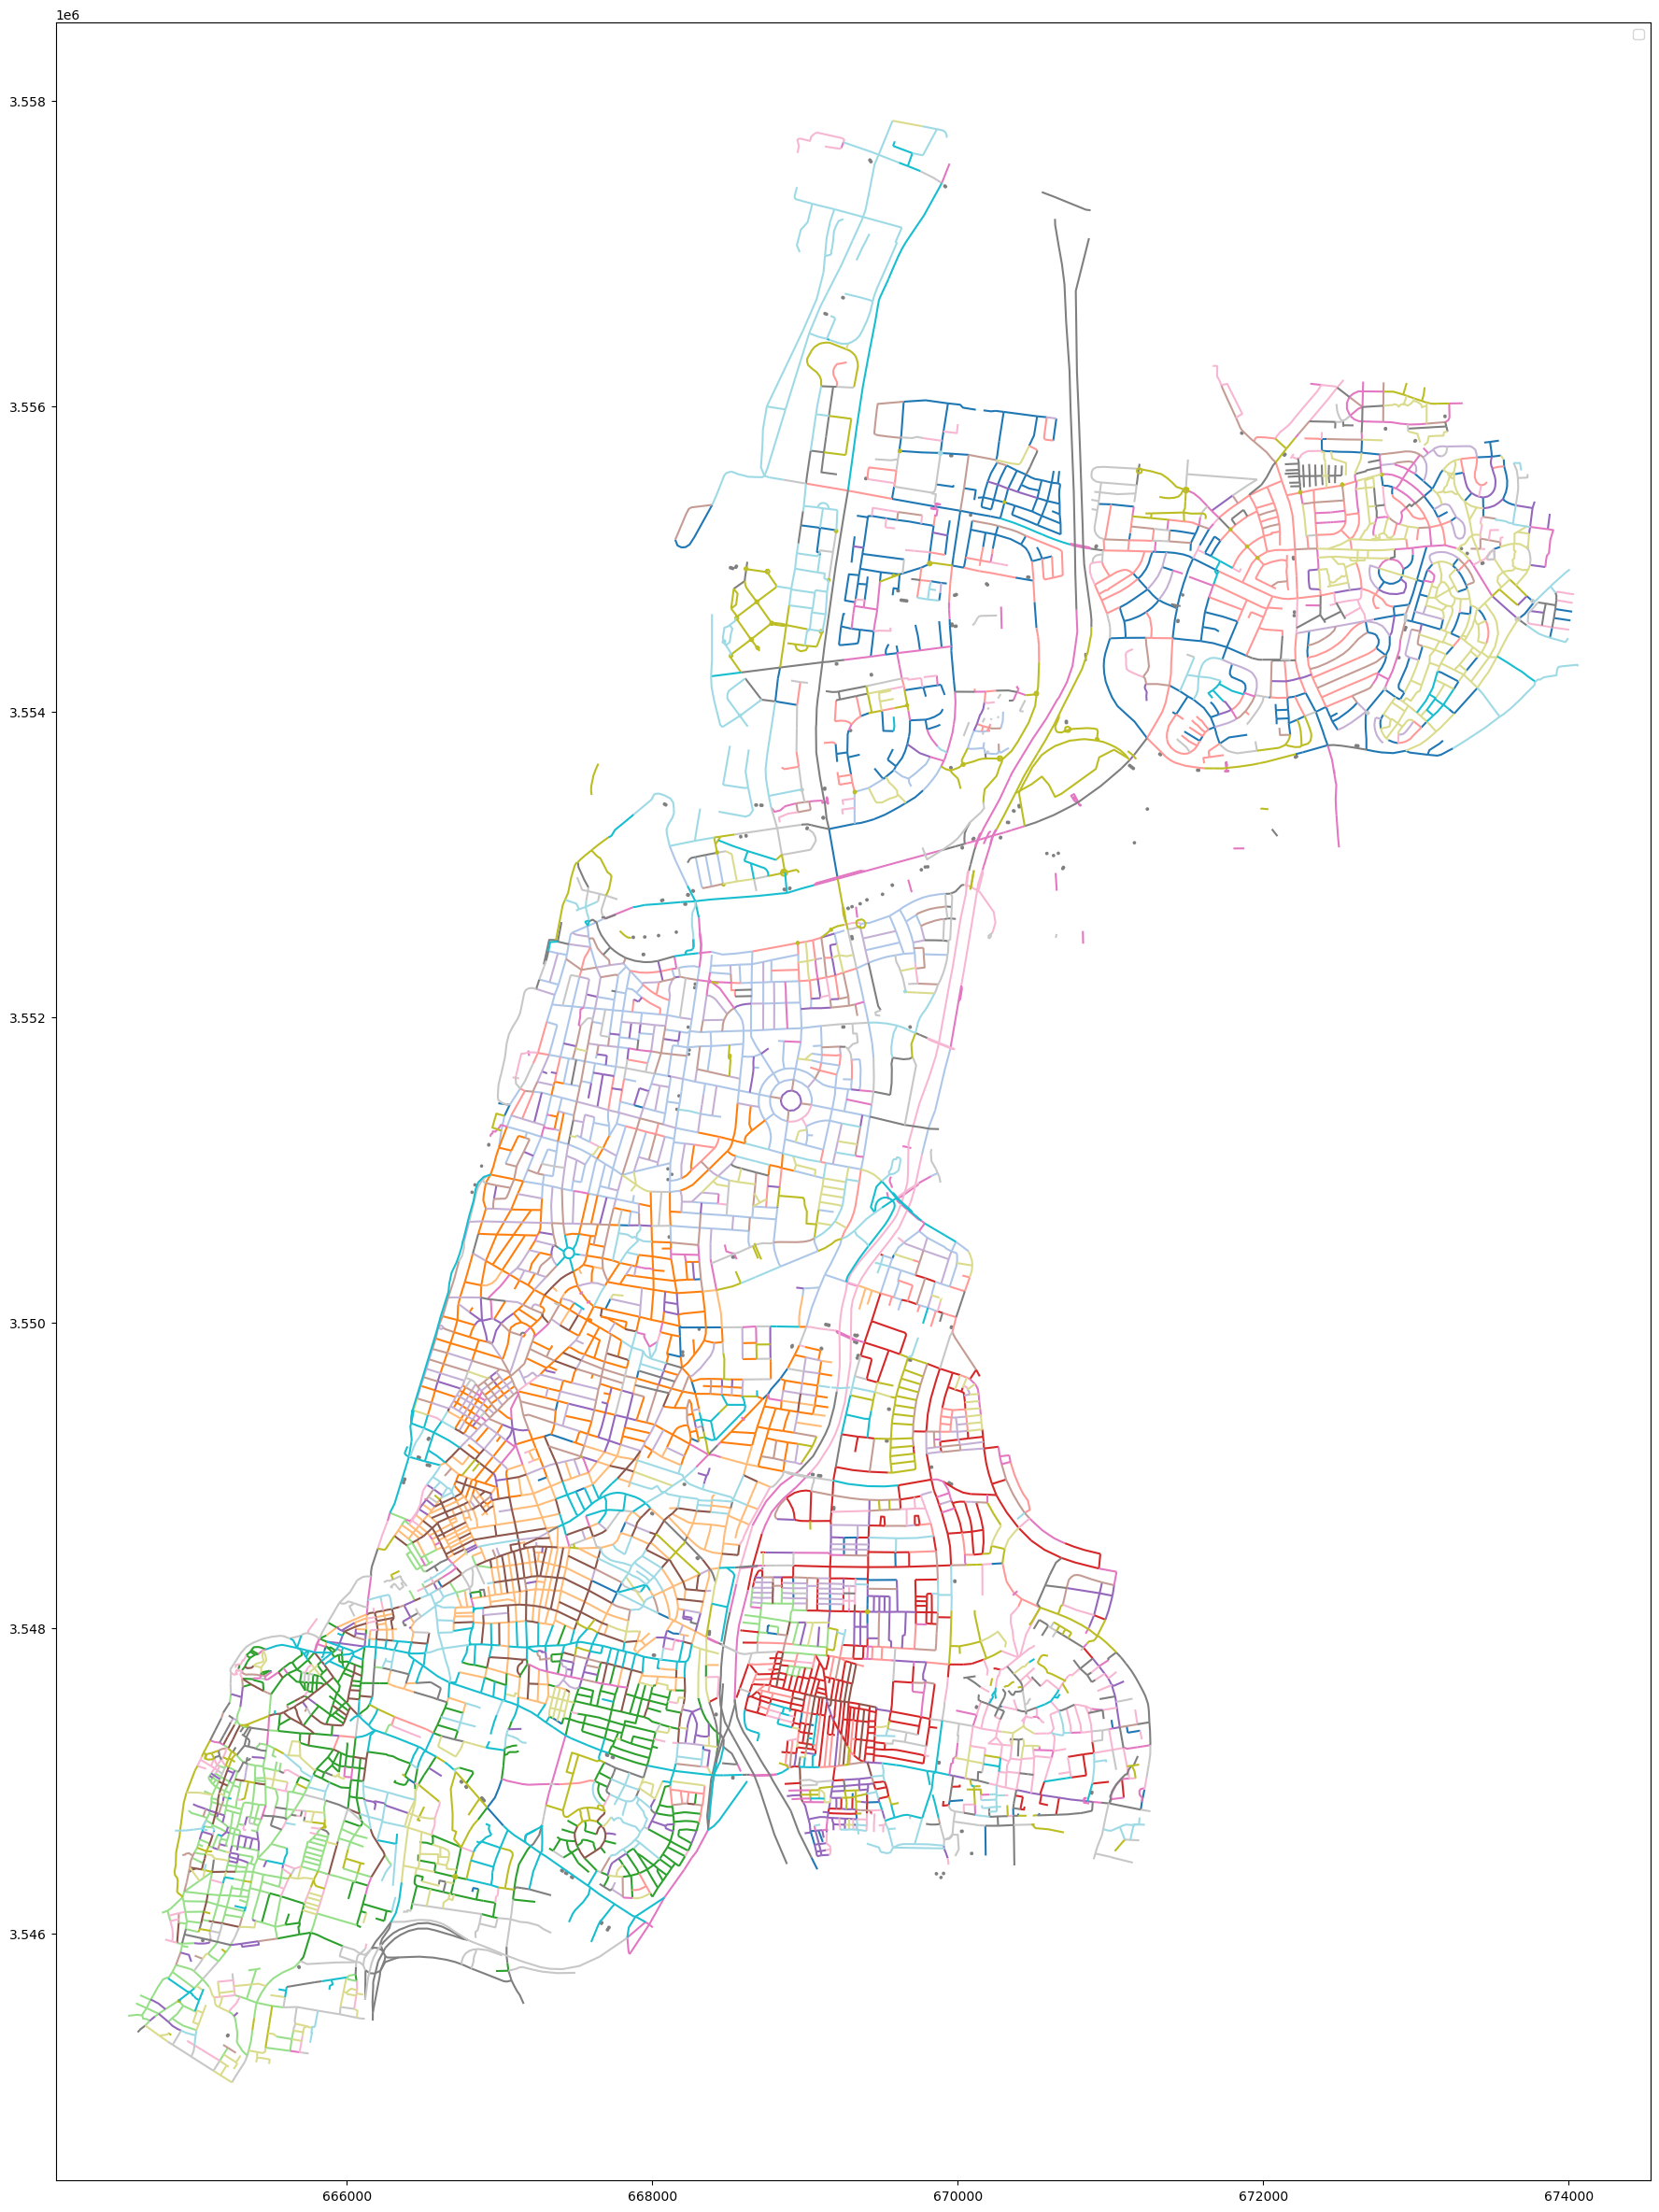

In [37]:
fig, ax = plt.subplots(figsize=(30, 30))
crossroads_poly[crossroads_poly.index.isin(difference_list)].plot(ax=ax, color='black', linewidth=5, alpha=0.5)
ta_streets.plot(ax=ax, cmap='tab20')

plt.legend()
plt.show()

In [38]:
ta_street_crossroads.index_right.value_counts()

index_right
2907    11
609      9
880      8
312      8
2689     8
        ..
2356     1
2343     1
2390     1
1059     1
1728     1
Name: count, Length: 2766, dtype: int64

In [39]:
ta_street_crossroads[ta_street_crossroads.index_right == 2907]

oidrechov  krechov      trechov         shemangli  mslamas  tsug  \
1199     1216.0    406.0  המלך ג'ורג'  HA-MELEKH GEORGE    738.0  רחוב   
1200     1217.0    406.0  המלך ג'ורג'  HA-MELEKH GEORGE    738.0  רחוב   
1201     1218.0    426.0      אלמונית    ALMONIT SIMTAT   1118.0  סמטת   
1202     1219.0    406.0  המלך ג'ורג'  HA-MELEKH GEORGE    738.0  רחוב   
1203     1220.0    406.0  המלך ג'ורג'  HA-MELEKH GEORGE    738.0  רחוב   
1204     1221.0     81.0        המכבי          HAMAKABI   1133.0  רחוב   
3708     3765.0    425.0       פלונית     PLONIT SIMTAT   1120.0  סמטת   
4013     4084.0    427.0   אלו מציאות       ELU METSIOT   1136.0  סמטת   
4379     4457.0     21.0       העבודה          HA'AVODA   1114.0  רחוב   
4380     4458.0    406.0  המלך ג'ורג'  HA-MELEKH GEORGE    738.0  רחוב   
6109     6339.0    406.0  המלך ג'ורג'  HA-MELEKH GEORGE    738.0  רחוב   

      kkivun   UniqueId    shemarvit  kreka  \
1199     0.0  507-11375  الملك جورج'  200.0   
1200     0.0  507-11376  الملك جورج'  200.0   
1201     0.0  507-11377        مجهول   50.0   
1202     0.0  507-11378  الملك جورج'  200.0   
1203     0.0  507-11379  الملك جورج'  200.0   
1204     1.0  507-11380        مكابي  100.0   
3708     0.0  507-14399         بيلي   50.0   
4013     1.0  507-14769    هذه حقيقة   50.0   
4379     2.0  507-15176        العمل  100.0   
4380     2.0  507-15177  الملك جورج'  200.0   
6109     2.0  507-17469  الملك جورج'  200.0   

                                               geometry  index_right  
1199  LINESTRING (667265.096 3549660.432, 667295.312...         2907  
1200  LINESTRING (667320.706 3549715.778, 667358.804...         2907  
1201  LINESTRING (667320.706 3549715.778, 667328.219...         2907  
1202  LINESTRING (667306.901 3549703.870, 667320.706...         2907  
1203  LINESTRING (667295.312 3549693.647, 667306.901...         2907  
1204  LINESTRING (667174.483 3549767.531, 667306.901...         2907  
3708  LINESTRING (667295.312 3549693.647, 667301.920...         2907  
4013  LINESTRING (667216.261 3549675.030, 667245.791...         2907  
4379  LINESTRING (667265.096 3549660.432, 667414.948...         2907  
4380  LINESTRING (667245.791 3549646.192, 667265.096...         2907  
6109  LINESTRING (667194.557 3549608.406, 667245.791...         2907

In [40]:
# unique_counts = (
#     i_m_h_ta_mm_crossroads_gdf.groupby('index_right')
#     .agg(
#         unique_street1_hebrew=('street1_hebrew', lambda x: x.nunique(dropna=True)),
#         unique_street2_hebrew=('street2_hebrew', lambda x: x.nunique(dropna=True))
#     )
#     .reset_index()
# )

In [41]:
# u_c_street_for_crossroad = (ta_street_crossroads.groupby('index_right')
#                             .agg(num_unique_streets)
#                             )

Getting top 10 crossroad by accidents count.

In [42]:
t10_crossroad_id = i_m_h_ta_mm_crossroads_gdf.value_counts(subset='index_right').head(10).index
print(t10_crossroad_id)
i_m_h_ta_mm_crossroads_gdf_t10 = i_m_h_ta_mm_crossroads_gdf[i_m_h_ta_mm_crossroads_gdf.index_right.isin(t10_crossroad_id)]
i_m_h_ta_mm_crossroads_gdf_t10

Index([1065, 1058, 1430, 1709, 962, 1464, 874, 1384, 685, 965], dtype='int64', name='index_right')


accident_id  provider_and_id  provider_code  file_type_police  \
580      2013004110      12013004110              1                 1   
2759     2013015911      12013015911              1                 1   
4865     2013024676      12013024676              1                 1   
7642     2013037036      12013037036              1                 1   
9775     2013043911      12013043911              1                 1   
...             ...              ...            ...               ...   
109867   2024040748      12024040748              1                 1   
109917   2024041727      12024041727              1                 1   
109962   2024037537      32024037537              3                 3   
110204   2024051752      32024051752              3                 3   
111249   2024095525      32024095525              3                 3   

        involved_type involved_type_hebrew  license_acquiring_date  age_group  \
580                 2             נהג נפגע                       0          7   
2759                2             נהג נפגע                       0          7   
4865                1                  נהג                       0          7   
7642                1                  נהג                       0          9   
9775                2             נהג נפגע                    2002          6   
...               ...                  ...                     ...        ...   
109867              2             נהג נפגע                    2008          7   
109917              2             נהג נפגע                    1985         14   
109962              1                  נהג                       0         99   
110204              2             נהג נפגע                       0         99   
111249              2             נהג נפגע                       0         99   

       age_group_hebrew  sex  ... vehicle_attribution_hebrew  seats  \
580               30-34    1  ...                     ישראלי   99.0   
2759              30-34    2  ...                     ישראלי   99.0   
4865              30-34    1  ...                     ישראלי   99.0   
7642              40-44    1  ...                     ישראלי   99.0   
9775              25-29    1  ...                     ישראלי   99.0   
...                 ...  ...  ...                        ...    ...   
109867            30-34    1  ...                     ישראלי   99.0   
109917            65-69    1  ...                     ישראלי   99.0   
109962          לא ידוע    0  ...                     ישראלי   99.0   
110204          לא ידוע    0  ...                     ישראלי   99.0   
111249          לא ידוע    0  ...                     ישראלי   99.0   

       total_weight  total_weight_hebrew vehicle_damage  \
580             0.0              לא ידוע            1.0   
2759            0.0              לא ידוע            1.0   
4865            0.0              לא ידוע            1.0   
7642            0.0              לא ידוע            4.0   
9775            0.0              לא ידוע            1.0   
...             ...                  ...            ...   
109867          0.0              לא ידוע            4.0   
109917          0.0              לא ידוע            4.0   
109962          0.0              לא ידוע            4.0   
110204          0.0              לא ידוע            1.0   
111249          0.0              לא ידוע            1.0   

        vehicle_damage_hebrew urban_intersection        accident_date  \
580                        קל         12280911.0  2013-04-24 06:30:00   
2759                       קל         13320815.0  2013-04-22 09:45:00   
4865                       קל         12280911.0  2013-09-25 12:15:00   
7642                  אין נזק                NaN  2013-02-25 15:30:00   
9775                       קל         12950556.0  2013-07-04 16:45:00   
...                       ...                ...                  ...   
109867                אין נזק         15130624.0  2024-01-08 12:00:00   
109917      

Creating crossroads name

C:\Users\itay8\AppData\Local\Temp\ipykernel_19944\4247611794.py:28: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


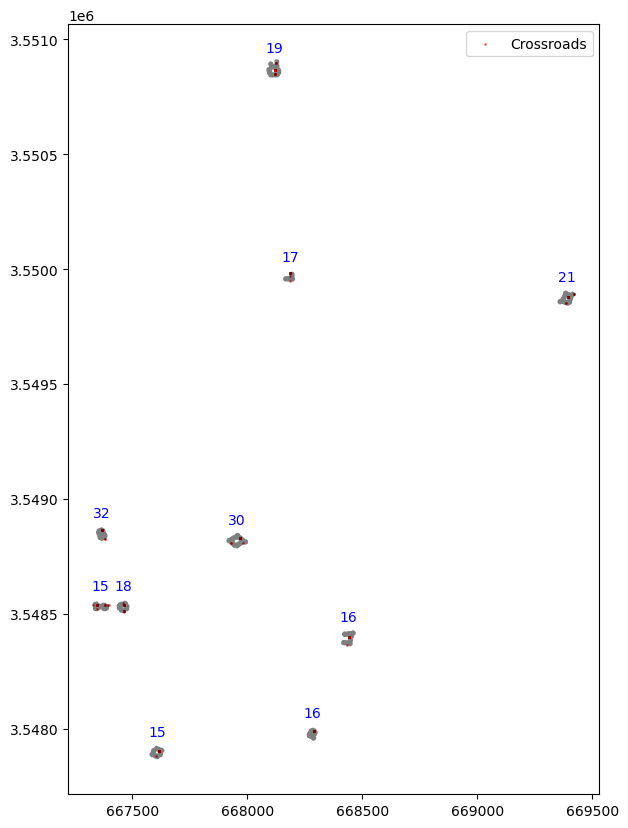

In [43]:
# Step 1: Get the count of `index_right`
v_counts_crossroad_idx = i_m_h_ta_mm_crossroads_gdf_.value_counts(subset='index_right')

# Step 2: Prepare the figure and axes
fig, ax = plt.subplots(figsize=(10, 10))

# Step 3: Plot points and polygons
# Plot the points
i_m_h_ta_mm_crossroads_gdf_t10.plot(
    ax=ax, color='red', marker='o', markersize=1, alpha=0.5, label="Crossroads"
)

# Plot the polygons with matching `index_right`
filtered_crossroads = crossroads_poly[crossroads_poly.index.isin(i_m_h_ta_mm_crossroads_gdf_t10.index_right)]
filtered_crossroads.plot(ax=ax, color='black', alpha=0.5, label="Polygons")

# Step 4: Annotate polygons with v_counts_crossroad_idx
for idx, row in filtered_crossroads.iterrows():
    count = v_counts_crossroad_idx.get(idx, 0)  # Get the count for this index; default to 0 if not found
    centroid = row.geometry.centroid  # Calculate the centroid of the polygon
    ax.text(
        centroid.x, centroid.y + 60,  # Add an offset to the y-coordinate
        str(count),  # The text to display
        fontsize=10, color="blue", ha='center', va='bottom', 
    )

# Step 5: Customize legend and show the plot
plt.legend()
plt.show()


Plotting top 10 crossroads by from 2013 - 2023 and number of accidents

Getting the top 10 crossroad_ index right by year



### Attempt 2 in creating the crossroads

Going over ta_streets and creating valid crossroads from the intersections between street parts.

In [128]:
# Import necessary libraries
from shapely.geometry import LineString
import geopandas as gpd

def split_linestrings_by_length(gdf, split_length=10):
    """Split each LineString in a GeoDataFrame into two LineStrings:
    one starting from the start point with the specified length
    and one ending at the endpoint with the specified length."""
    new_rows = []
    
    for i, row in gdf.iterrows():
        geometry = row.geometry
        
        # Check if the geometry is a LineString
        if isinstance(geometry, LineString):
            length = geometry.length
            
            # Ensure the split length is valid
            if split_length * 2 >= length:
                # If the split length exceeds the total length, skip splitting
                continue
            
            # Compute the two split points
            split_point_start = geometry.interpolate(split_length)
            split_point_end = geometry.interpolate(length - split_length)
            
            # Create two new LineStrings
            first_segment = LineString([geometry.coords[0], split_point_start.coords[0]])
            second_segment = LineString([split_point_end.coords[0], geometry.coords[-1]])
            # print('first half',first_segment.length, 'second_half', second_segment.length)
            
            # Append new rows with the original attributes and new geometries
            new_rows.append({**row.to_dict(), "geometry": first_segment})
            new_rows.append({**row.to_dict(), "geometry": second_segment})
    
    # Create a new GeoDataFrame with the split LineStrings
    return gpd.GeoDataFrame(new_rows, crs=gdf.crs)

# Example GeoDataFrame
data = {
    "id": [1, 2],
    "geometry": [
        LineString([(0, 0), (20, 0)]),
        LineString([(0, 0), (0, 30)]),
    ],
}
example_gdf = gpd.GeoDataFrame(data, crs="EPSG:4326")

# Split the LineStrings with a length of 10
split_gdf = split_linestrings_by_length(example_gdf, split_length=10)

# Display the resulting GeoDataFrame
# import ace_tools as tools; tools.display_dataframe_to_user(name="Split LineStrings by Length GeoDataFrame", dataframe=split_gdf)


In [129]:
# import geopandas as gpd
# from shapely.geometry import LineString
# import pandas as pd

# def split_linestrings_half(gdf):
#     """Split each LineString in a GeoDataFrame into two LineStrings, 
#     each half the length of the original."""
#     new_rows = []
    
#     for i, row in gdf.iterrows():
#         geometry = row.geometry
        
#         # Check if the geometry is a LineString
#         if isinstance(geometry, LineString):
#             length = geometry.length
#             print(length, geometry)
#             # if length < 20:
#             #     split_point_1 = geometry.interpolate(length * 0.25)
#             #     split_point_2 = geometry.interpolate(length * 0.75)
#             # else:
            
#             split_point_1 = geometry.interpolate(10)
#             split_point_2 = geometry.interpolate(10)
            
#             # Create two new LineStrings
#             first_half = LineString([geometry.coords[0], split_point_1.coords[0]])
#             second_half = LineString([split_point_2.coords[0], geometry.coords[-1]])
#             # print('first half',split_point_1, first_half.length, 'second_half', second_half.length)
#             # Append new rows with the original attributes and new geometries
#             new_rows.append({**row.to_dict(), "geometry": first_half})
#             new_rows.append({**row.to_dict(), "geometry": second_half})
    
#     # Create a new GeoDataFrame with the split LineStrings
#     return gpd.GeoDataFrame(new_rows, crs=gdf.crs)

# # Example GeoDataFrame
# data = {
#     "id": [1, 2],
#     "geometry": [
#         LineString([(0, 0), (1, 0)]),
#         LineString([(2, 2), (4, 2)]),
#     ],
# }
# example_gdf = gpd.GeoDataFrame(data, crs="EPSG:4326")

# # Split the LineStrings in the example GeoDataFrame
# split_gdf = split_linestrings_half(example_gdf)

# split_gdf

(16960, 11)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


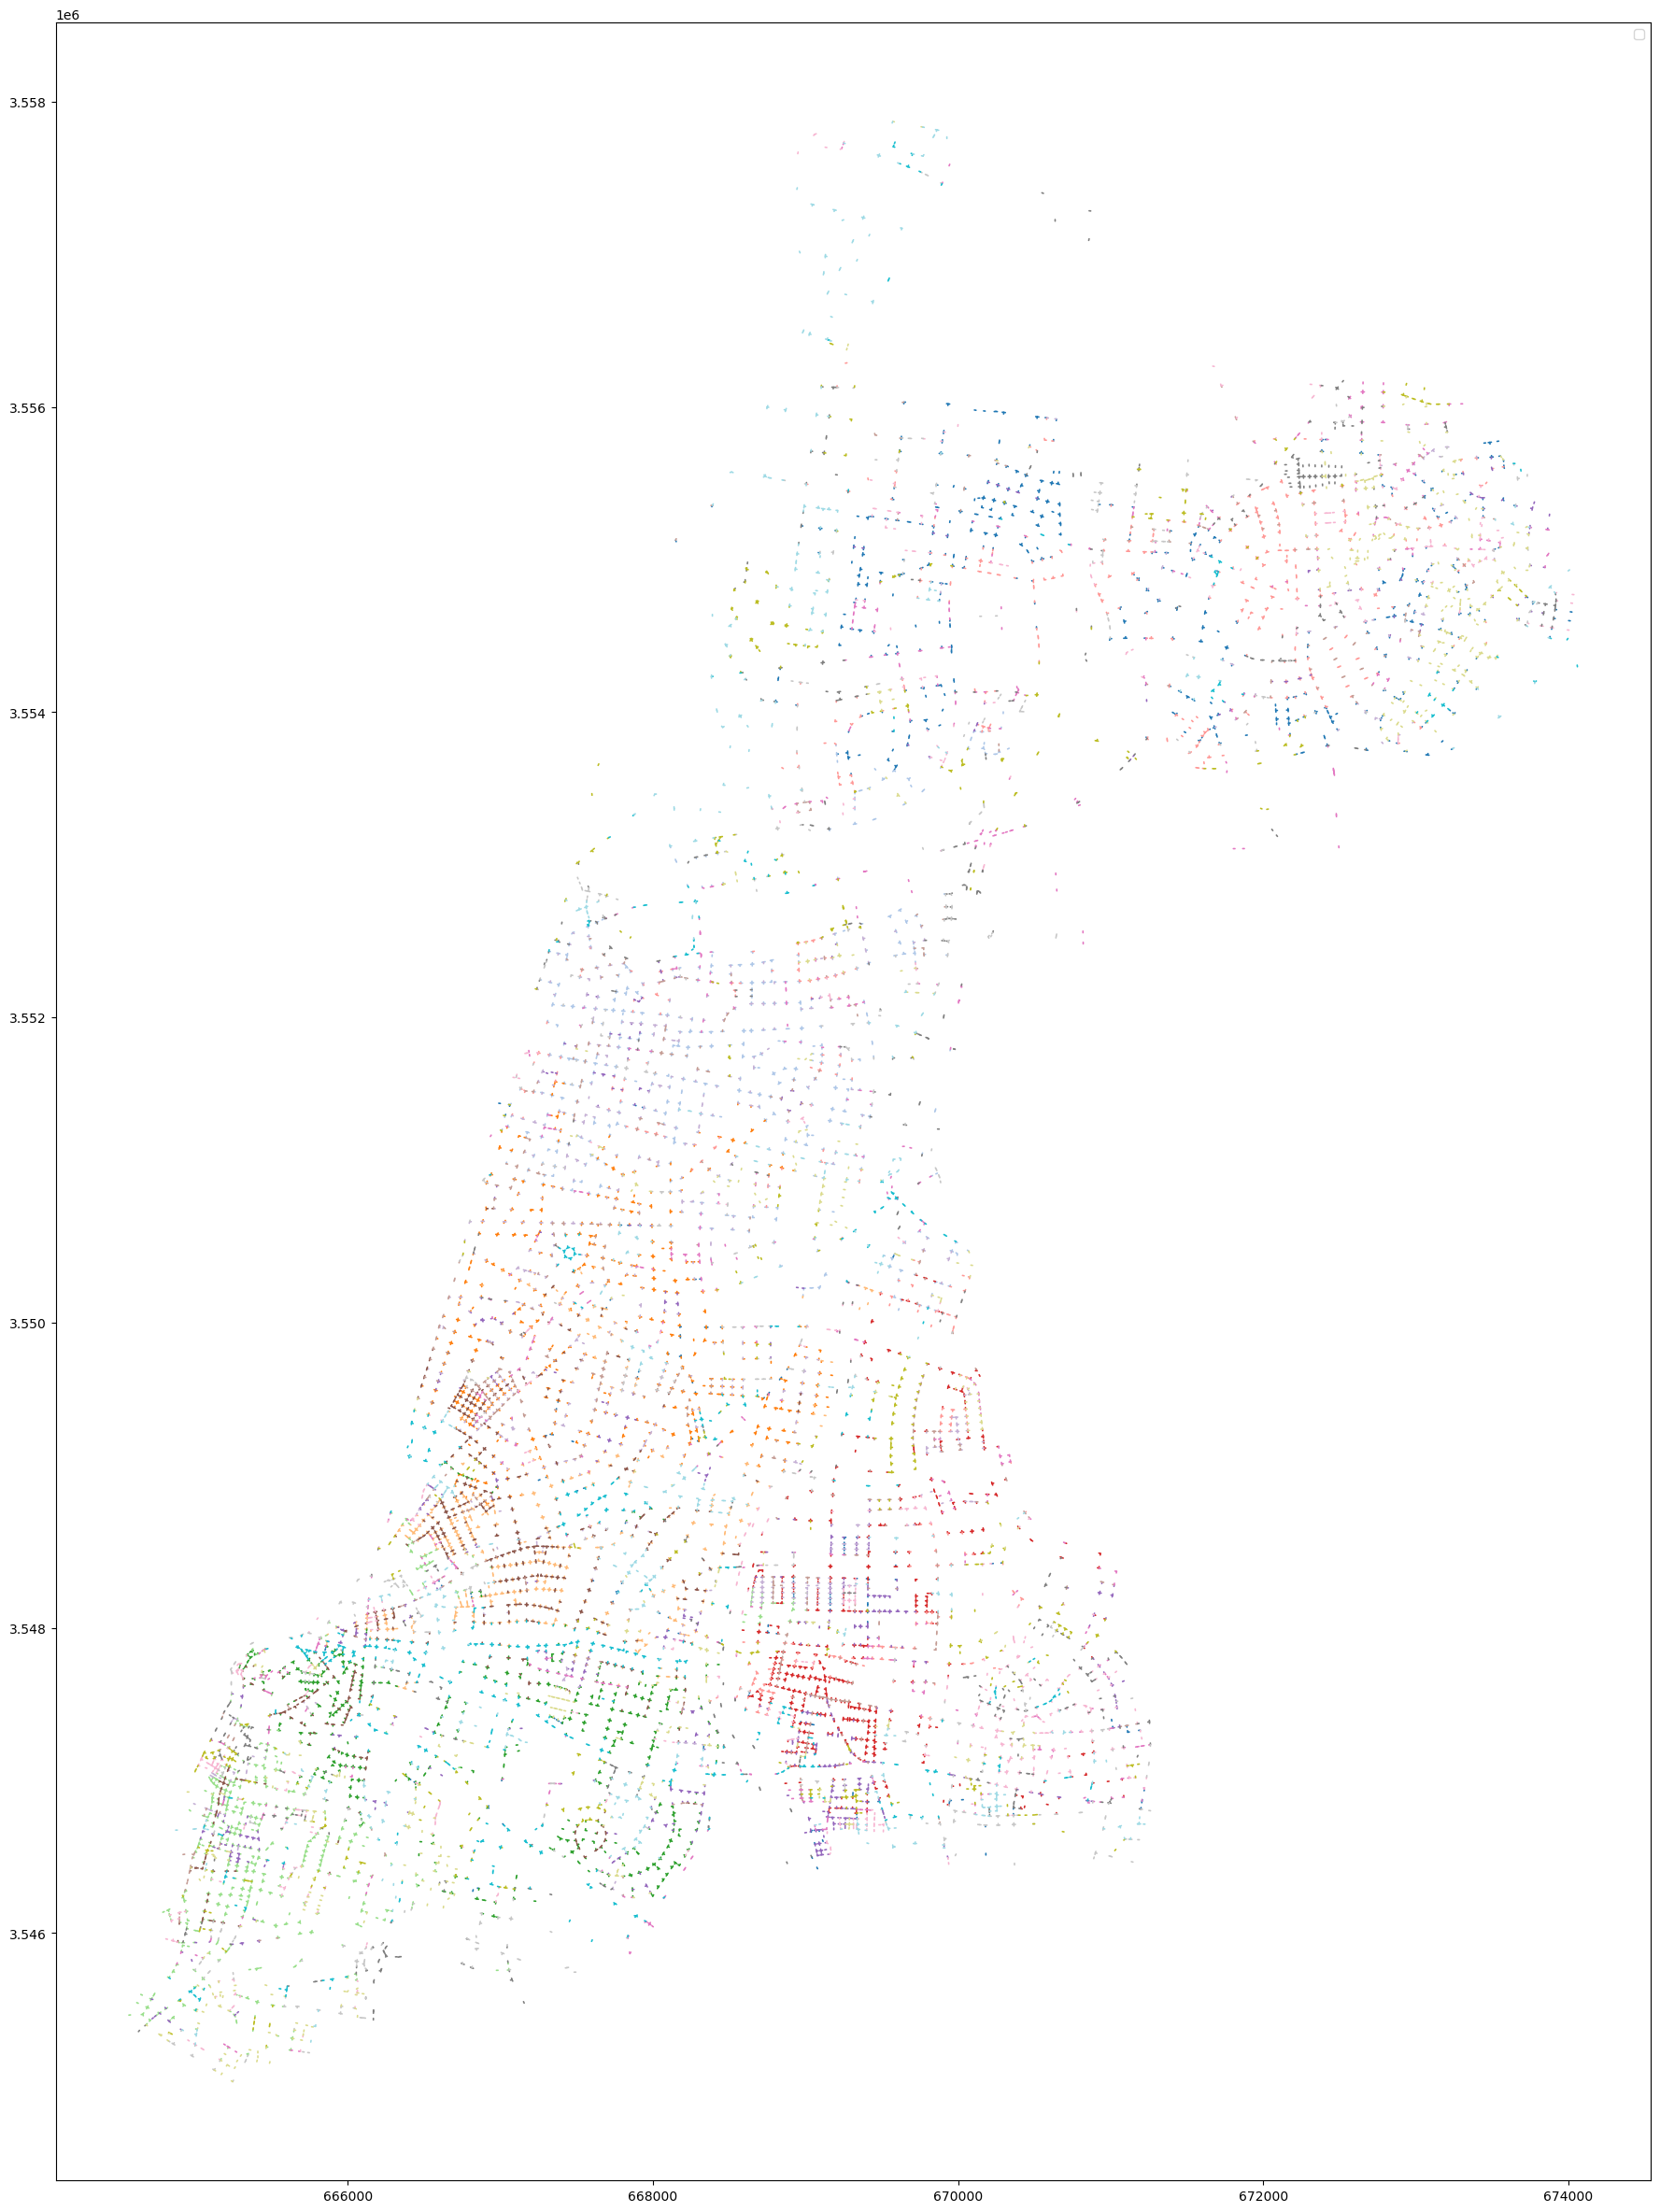

In [139]:
# Split the LineStrings in the example GeoDataFrame
ta_crossroads_from_streets = split_linestrings_by_length(ta_streets)
ta_crossroads_from_streets['geometry'] = ta_crossroads_from_streets.geometry.buffer(5)
print(ta_crossroads_from_streets.shape)

fig, ax = plt.subplots(figsize=(30, 30))
ta_crossroads_from_streets.plot(ax=ax, cmap='tab20')

plt.legend()
plt.show()

In [153]:
combined_polygons = ta_crossroads_from_streets.dissolve().explode()
print(combined_polygons.shape)


combined_polygons['geo_length'] = combined_polygons.geometry.length
combined_polygons = combined_polygons.reset_index().drop(columns=['level_1','level_0'])
combined_polygons

(5628, 11)


C:\Users\itay8\AppData\Local\Temp\ipykernel_19944\2278547393.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  combined_polygons = ta_crossroads_from_streets.dissolve().explode()


oidrechov  krechov      trechov        shemangli  mslamas  tsug  kkivun  \
0           1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
1           1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
2           1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
3           1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
4           1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
...         ...      ...          ...              ...      ...   ...     ...   
5623        1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
5624        1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
5625        1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
5626        1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
5627        1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   

       UniqueId  shemarvit  kreka  \
0     507-10001  قتل مملكة  100.0   
1     507-10001  قتل مملكة  100.0   
2     507-10001  قتل مملكة  100.0   
3     507-10001  قتل مملكة  100.0   
4     507-10001  قتل مملكة  100.0   
...         ...        ...    ...   
5623  507-10001  قتل مملكة  100.0   
5624  507-10001  قتل مملكة  100.0   
5625  507-10001  قتل مملكة  100.0   
5626  507-10001  قتل مملكة  100.0   
5627  507-10001  قتل مملكة  100.0   

                                               geometry  geo_length  
0     POLYGON ((665251.028 3545022.970, 665250.991 3...   69.100794  
1     POLYGON ((665173.003 3545083.704, 665173.279 3...   51.403312  
2     POLYGON ((665136.784 3545100.508, 665137.185 3...   87.109020  
3     POLYGON ((665262.291 3545110.298, 665262.003 3...   51.390955  
4     POLYGON ((665227.787 3545131.528, 665228.177 3...   82.956372  
...                                                 ...         ...  
5623  POLYGON ((669845.350 3557772.019, 669845.346 3...   71.403332  
5624  POLYGON ((669241.826 3557690.173, 669241.781 3...   71.138641  
5625  POLYGON ((669140.042 3557704.879, 669140.522 3...   51.403312  
5626  POLYGON ((669586.350 3557706.521, 669586.804 3...   69.133970  
5627  POLYGON ((669567.411 3557871.865, 669567.505 3...   70.097456  

[5628 rows x 12 columns]

In [149]:
combined_polygons[combined_polygons.geo_length >300]


oidrechov  krechov      trechov        shemangli  mslamas  tsug  kkivun  \
394         1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
441         1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
600         1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
660         1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
733         1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
792         1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
797         1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
881         1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
891         1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
978         1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
1107        1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
1113        1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
1436        1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
1470        1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
1619        1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
1677        1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
1698        1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
2466        1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
2497        1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
2508        1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
2644        1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   
3044        1.0    915.0  הרוגי מלכות  HARUGEY MALKHOT    336.0  רחוב     0.0   

       UniqueId  shemarvit  kreka  \
394   507-10001  قتل مملكة  100.0   
441   507-10001  قتل مملكة  100.0   
600   507-10001  قتل مملكة  100.0   
660   507-10001  قتل مملكة  100.0   
733   507-10001  قتل مملكة  100.0   
792   507-10001  قتل مملكة  100.0   
797   507-10001  قتل مملكة  100.0   
881   507-10001  قتل مملكة  100.0   
891   507-10001  قتل مملكة  100.0   
978   507-10001  قتل مملكة  100.0   
1107  507-10001  قتل مملكة  100.0   
1113  507-10001  قتل مملكة  100.0   
1436  507-10001  قتل مملكة  100.0   
1470  507-10001  قتل مملكة  100.0   
1619  507-10001  قتل مملكة  100.0   
1677  507-10001  قتل مملكة  100.0   
1698  507-10001  قتل مملكة  100.0   
2466  507-10001  قتل مملكة  100.0   
2497  507-10001  قتل مملكة  100.0   
2508  507-10001  قتل مملكة  100.0   
2644  507-10001  قتل مملكة  100.0   
3044  507-10001  قتل مملكة  100.0   

                                               geometry  geo_length  
394   POLYGON ((665220.022 3546437.888, 665219.901 3...  397.047146  
441   POLYGON ((669087.116 3546513.295, 669087.600 3...  319.089798  
600   POLYGON ((669320.048 3546684.341, 669320.034 3...  335.301705  
660   POLYGON ((669343.979 3546738.237, 669343.987 3...  302.996312  
733   POLYGON ((665208.254 3546799.085, 665208.125 3...  679.407809  
792   POLYGON ((668994.554 3546855.911, 668994.799 3...  339.646468  
797   POLYGON ((669046.092 3546865.995, 669046.582 3...  326.530708  
881   POLYGON ((665142.336 3546949.298, 665142.108 3...  497.254696  
891   POLYGON ((665218.068 3546957.509, 665217.819 3...  312.401531  
978   POLYGON ((665150.577 3547047.155, 665150.971 3...  564.434988  
1107  POLYGON ((665274.053 3547165.269, 665274.030 3...  320.796432  
1113  POLYGON ((669071.067 3547173.092, 669071.042 3...  375.362471  
1436  POLYGON ((669287.772 3547485.783, 669287.772 3...  315.503344  
1470  POLYGON ((669143.894 3547503.090, 669143.846 3...  337.447604  
1619  POLYGON ((665750.746 3547633.319, 665750.672 3...  458.136902  
1677  POLYGON ((665811.002 3547677.700, 665810.927 3...  386.562857  
1698  POLYGON ((668831.112 3547693.765, 668830.992 3...  329.678913  
2466  POLYGON ((666776.940 354

In [142]:
combined_polygons.geo_length.max()

679.4078086770243

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


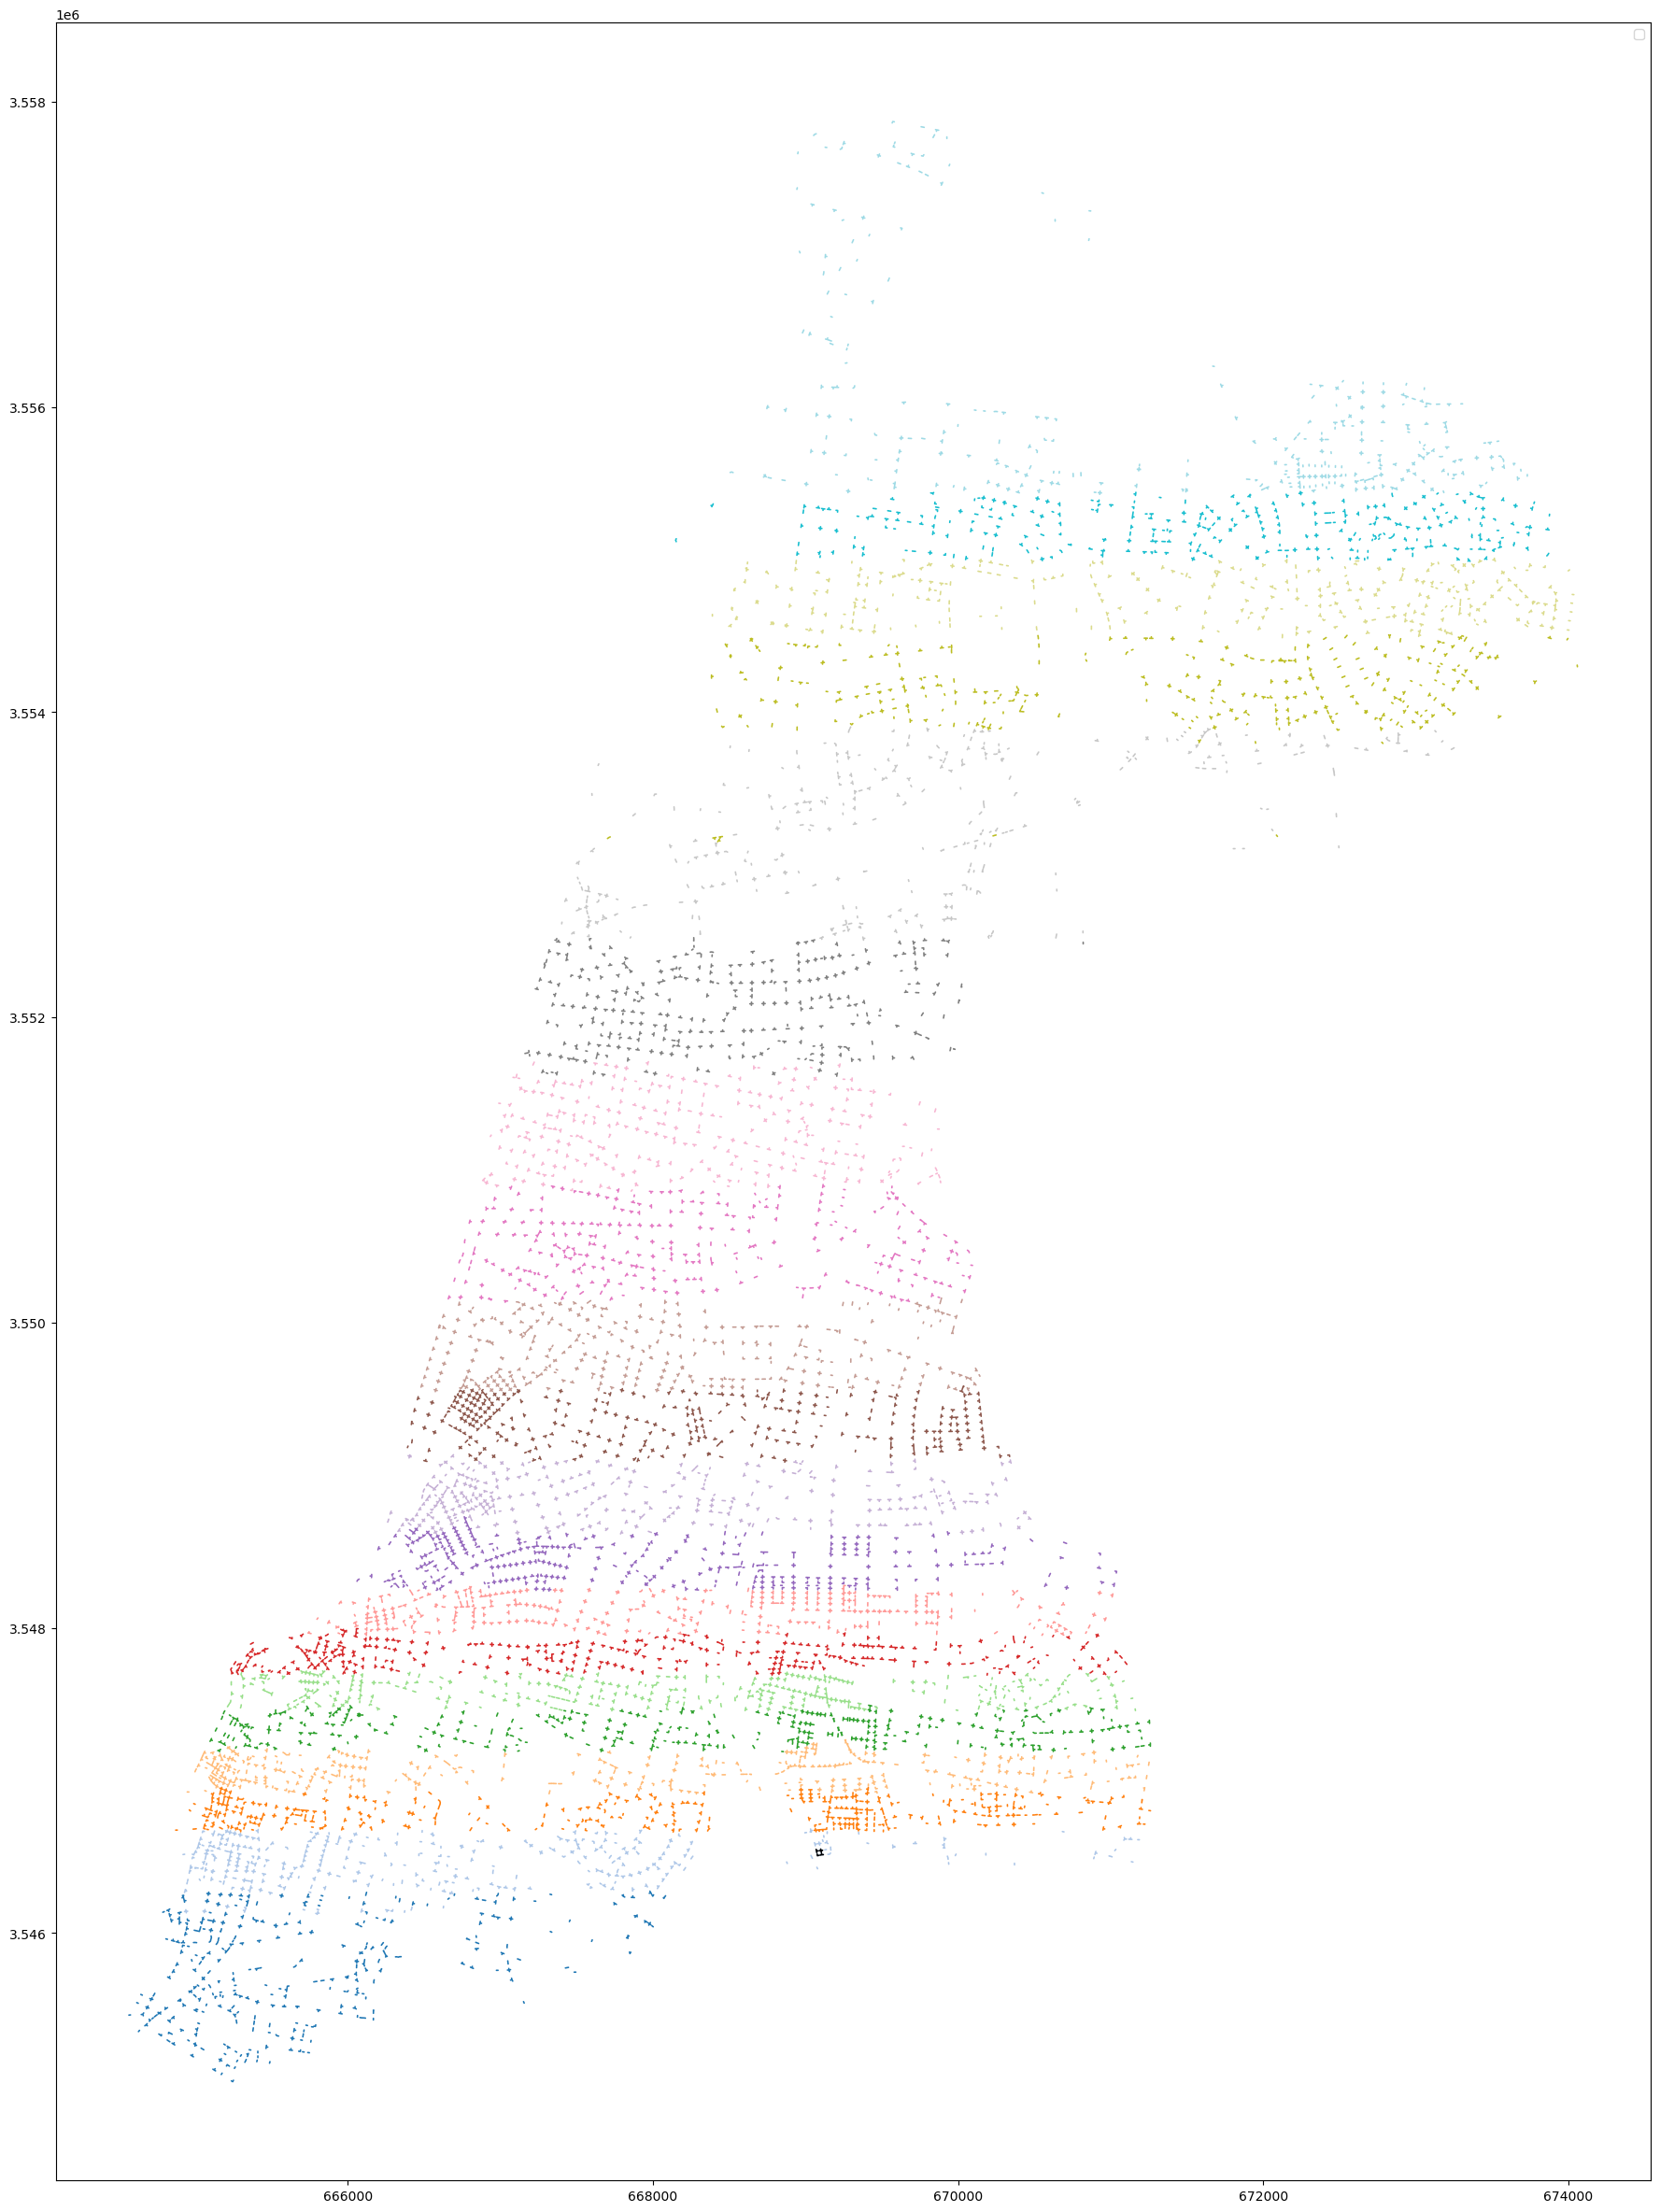

In [152]:
fig, ax = plt.subplots(figsize=(30, 30))
combined_polygons.plot(ax=ax, cmap='tab20')
combined_polygons[combined_polygons.index == 441].plot(ax=ax, color='black')

plt.legend()
plt.show()